# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/Abilene-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'MLP'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'MLP_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'MLP_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time     OD_1-1      OD_1-2       OD_1-3      OD_1-4  \
0  2004-03-01-00-00  26.666667  522.208000  1641.338667  335.728000   
1  2004-03-01-00-05  26.666667  465.701333   868.098667  148.346667   
2  2004-03-01-00-10  53.333333  375.261333  1082.378667  276.136000   
3  2004-03-01-00-15  67.274667  498.360000  1332.205333  121.269333   
4  2004-03-01-00-20  26.666667  723.962667  1428.480000  165.938667   

       OD_1-5       OD_1-6      OD_1-7       OD_1-8      OD_1-9  ...  \
0  413.032000   489.874667  365.077333   817.869333  452.061333  ...   
1  398.701333  1821.269333  402.144000  1090.848000  585.202667  ...   
2  453.426667  1703.384000  407.152000   403.664000  853.005333  ...   
3  425.168000   794.472000  506.746667   142.328000  818.728000  ...   
4  459.965333   403.757333  303.256000   257.877333  848.208000  ...   

        OD_12-3       OD_12-4       OD_12-5       OD_12-6       OD_12-7  \
0  66541.197333  36063.421333  15439.312000  62781.813333  32642.733333   
1  62246.088000  34109.810667  15664.965333  56823.610667  24912.210667   
2  70181.930667  29905.896000  19918.581333  58658.568000  19036.714667   
3  74490.416000  44822.789333  16250.042667  50589.922667  18758.725333   
4  69881.266667  44536.856000  18448.840000  51095.165333  18614.133333   

         OD_12-8        OD_12-9     OD_12-10      OD_12-11       OD_12-12  
0   91675.626667  133661.405333  1980.576000  29760.202667  187653.482667  
1  100567.461333  137277.728000  4411.589333  30667.266667  190925.981333  
2   92415.480000  153845.554667  5300.653333  39990.880000  218742.773333  
3   97793.093333  159339.533333  4490.272000  38331.688000  265665.077333  
4   93446.560000  151623.424000  3487.808000  43462.373333  210540.786667  

[5 rows x 145 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2004-07-12 14:25:00', freq='5T')

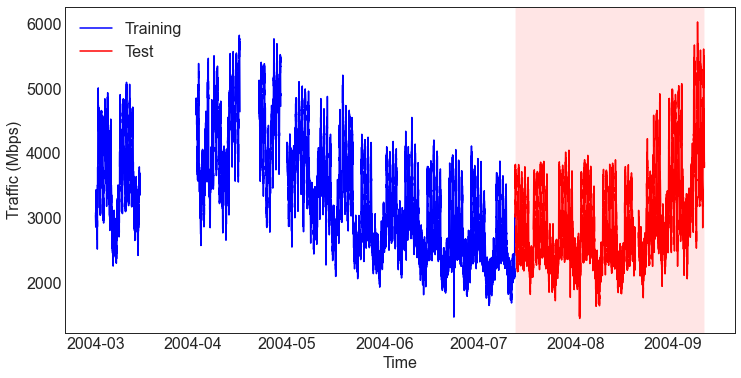

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

5.940447088662937


In [26]:
print(np.min(data.flatten()))

-0.0023245664896374284


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

48096


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(48086, 10, 144)

In [32]:
y_data.shape

(48086, 1, 144)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(48086, 144)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

38467

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

30773

In [40]:
valid_length

7694

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(30773, 144, 10)

In [43]:
y_train.shape

(30773, 144)

In [44]:
X_valid.shape

(7694, 144, 10)

In [45]:
y_valid.shape

(7694, 144)

In [46]:
X_test.shape

(9619, 144, 10)

In [47]:
y_test.shape

(9619, 144)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(38467, 144, 10)

In [50]:
y.shape

(38467, 144)

In [51]:
splits

((#30773) [0,1,2,3,4,5,6,7,8,9...],
 (#7694) [30773,30774,30775,30776,30777,30778,30779,30780,30781,30782...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#38467) [(TSTensor(vars:144, len:10), tensor([2.0469e-03, 5.1440e-02, 1.4299e-01, 1.5172e-02, 3.1831e-02, 2.1060e-02,
        5.6545e-02, 2.7428e-02, 2.8036e-01, 0.0000e+00, 4.0722e-02, 8.6615e-02,
        5.2351e-02, 2.0172e-01, 2.2308e-01, 5.7753e-02, 2.0265e-02, 1.5293e-01,
        9.8783e-02, 1.2363e-01, 1.7657e-01, 3.3181e-02, 2.1478e-01, 3.0738e-01,
        9.3064e-02, 9.6376e-02, 1.5660e-01, 3.1830e-02, 4.6944e-02, 1.3623e-01,
        4.7996e-02, 9.0038e-02, 3.8663e-02, 3.1614e-02, 1.1989e-01, 4.8892e-02,
        7.9847e-03, 2.8893e-02, 1.8501e-01, 3.5594e-02, 1.7775e-02, 6.8981e-02,
        8.2558e-02, 8.7485e-02, 1.3270e-01, 7.0169e-02, 1.0452e-01, 2.8641e-02,
        2.3876e-01, 3.3501e-02, 1.7263e-01, 9.0359e-02, 4.2771e-02, 4.5059e-01,
        2.0892e-01, 1.9877e-02, 5.5563e-02, 1.0113e-01, 1.0701e-01, 3.5482e-02,
        1.2049e-01, 1.0425e-01, 4.3749e-01, 9.8969e-02, 7.4077e-02, 9.2987e-02,
        1.2642e-01, 1.1211e-01, 1.5237e-01, 7.5094e-02, 2.2026e-01, 1.6917e-01,
 

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "layers": hp.choice('layers', [[100, 100, 100], [200, 200, 200], [500, 500, 500]]),
    "fc_dropout": hp.choice('fc_dropout', [0.1, 0.2, 0.5])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x28945ac83c8>,
 'lr': <hyperopt.pyll.base.Apply at 0x28945ac8408>,
 'epochs': <hyperopt.pyll.base.Apply at 0x28945aae188>,
 'patience': <hyperopt.pyll.base.Apply at 0x28945aae108>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x28945aaeec8>,
 'layers': <hyperopt.pyll.base.Apply at 0x28945b5b9c8>,
 'fc_dropout': <hyperopt.pyll.base.Apply at 0x28936c2bf88>}

In [55]:
# clear memory 
gc.collect()

0

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = MLP
        k = {
            'layers': params['layers'],
            'fc_dropout': params['fc_dropout']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
  0%|                                                                          | 0/100 [00:06<?, ?trial/s, best loss=?]

No improvement since epoch 32: early stopping                                                                          
  0%|                                                                          | 0/100 [03:27<?, ?trial/s, best loss=?]

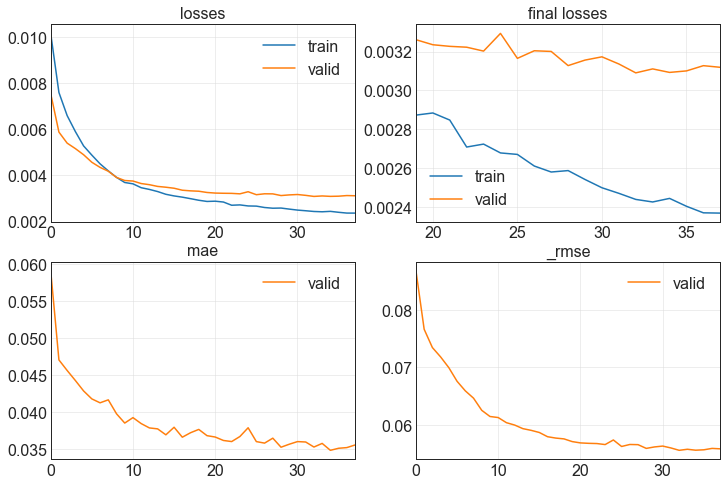

201.6196472644806                                                                                                      
[0.0023680899757891893, 0.0031187108252197504, 0.03559373691678047, 0.055845413357019424]                              
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
  1%|▍                                         | 1/100 [03:32<5:43:24, 208.13s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 82: early stopping                                                                          
  1%|▍                                         | 1/100 [05:46<5:43:24, 208.13s/trial, best loss: 0.0031187108252197504]

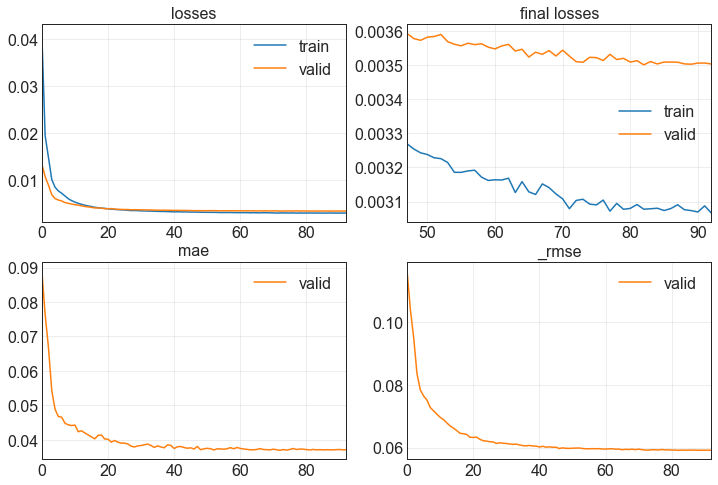

134.10647439956665                                                                                                     
[0.003066494595259428, 0.0035028562415391207, 0.03712086006999016, 0.059184931218624115]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
  2%|▊                                         | 2/100 [05:51<5:05:57, 187.32s/trial, best loss: 0.0031187108252197504]

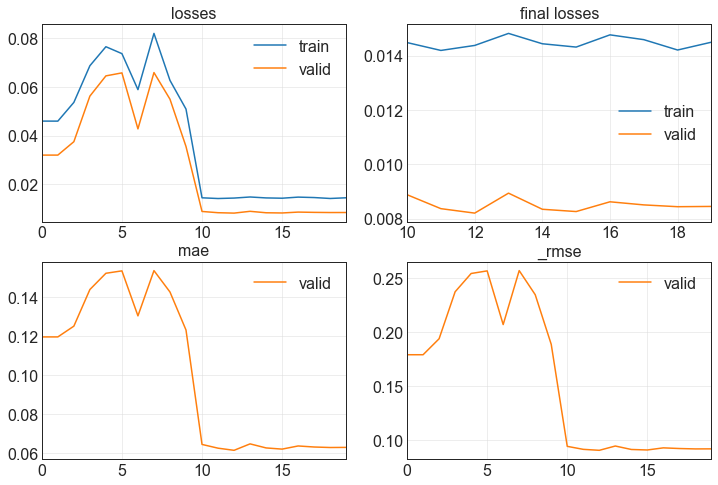

109.61848425865173                                                                                                     
[0.014497249387204647, 0.008448004722595215, 0.06307526677846909, 0.09191302210092545]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
  3%|█▎                                        | 3/100 [07:46<4:27:27, 165.44s/trial, best loss: 0.0031187108252197504]

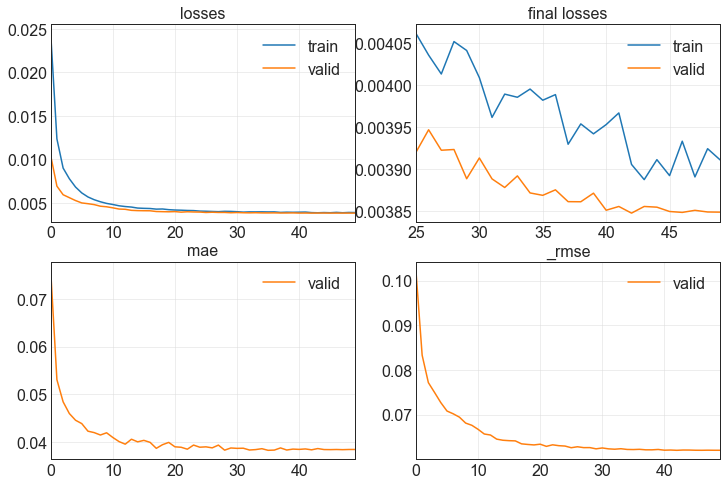

133.27129435539246                                                                                                     
[0.003910735249519348, 0.0038486167322844267, 0.03837702423334122, 0.06203722581267357]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
  4%|█▋                                        | 4/100 [10:04<4:11:32, 157.21s/trial, best loss: 0.0031187108252197504]

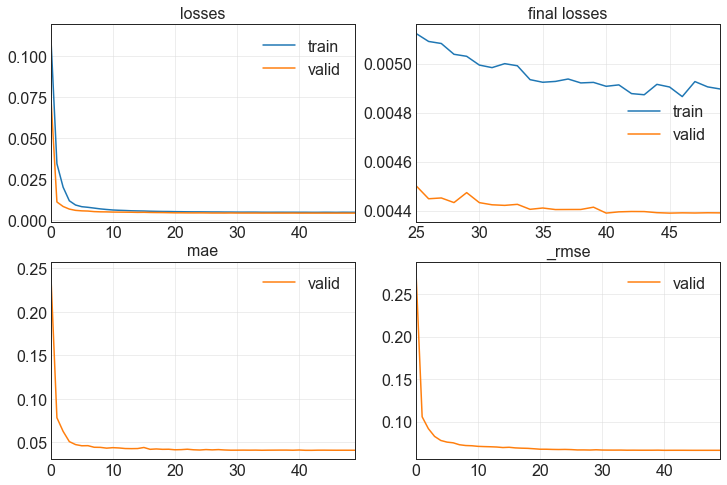

71.95294880867004                                                                                                      
[0.004896338097751141, 0.004390744026750326, 0.04078584164381027, 0.06626269221305847]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
  5%|██                                        | 5/100 [11:20<3:30:40, 133.06s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 66: early stopping                                                                          
  5%|██                                        | 5/100 [14:50<3:30:40, 133.06s/trial, best loss: 0.0031187108252197504]

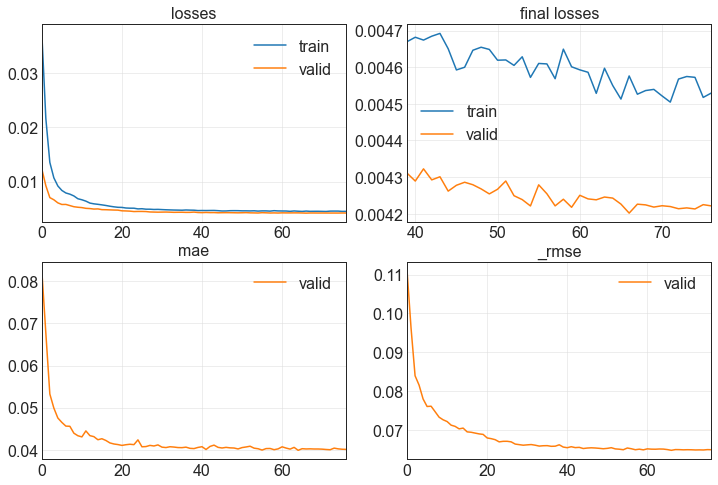

210.2122676372528                                                                                                      
[0.004529666155576706, 0.004221328999847174, 0.04009155184030533, 0.06497175246477127]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
  6%|██▌                                       | 6/100 [14:55<4:06:58, 157.64s/trial, best loss: 0.0031187108252197504]

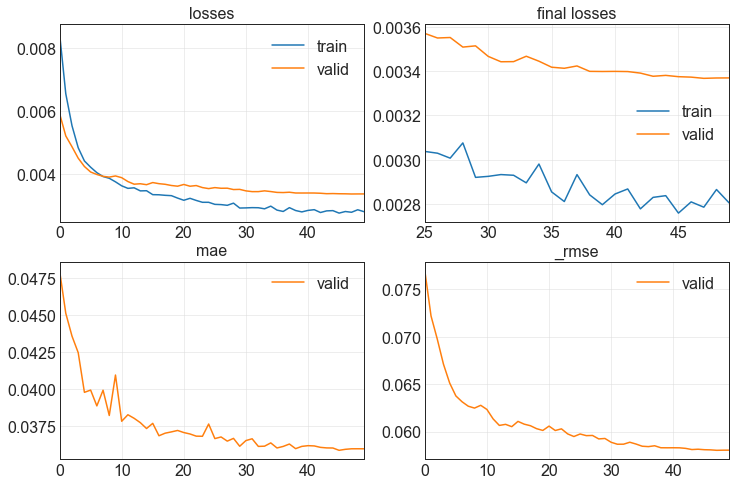

526.2481243610382                                                                                                      
[0.0028054695576429367, 0.003369427053257823, 0.035937655717134476, 0.058046769350767136]                              
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
  7%|██▉                                       | 7/100 [23:47<6:58:02, 269.70s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 4: early stopping                                                                           
  7%|██▉                                       | 7/100 [24:02<6:58:02, 269.70s/trial, best loss: 0.0031187108252197504]

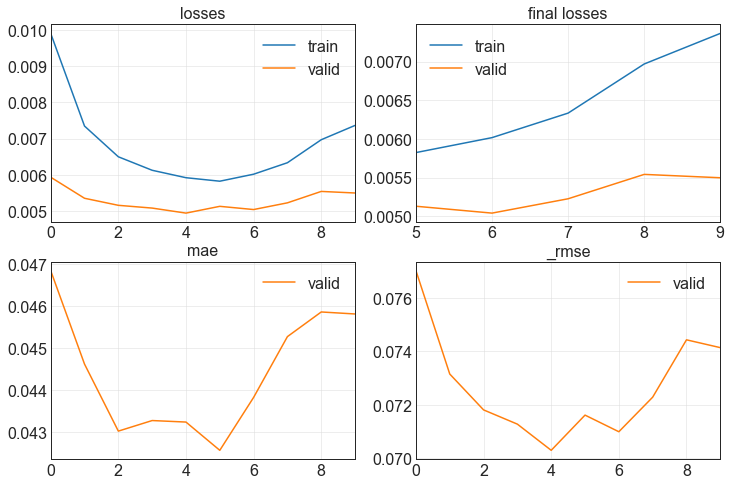

15.74900197982788                                                                                                      
[0.007365867029875517, 0.005497293081134558, 0.045806754380464554, 0.07414372265338898]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
  8%|███▎                                      | 8/100 [24:07<4:59:03, 195.04s/trial, best loss: 0.0031187108252197504]

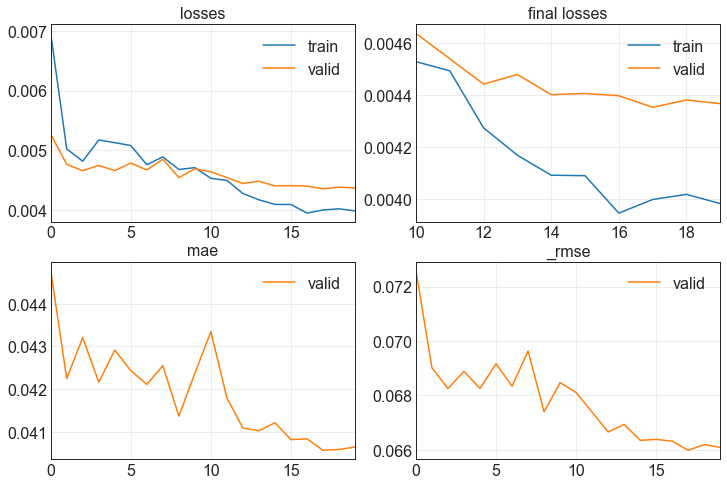

104.63525605201721                                                                                                     
[0.003981950227171183, 0.004367478657513857, 0.04064108803868294, 0.06608691811561584]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
  9%|███▊                                      | 9/100 [25:57<4:16:53, 169.38s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 5: early stopping                                                                           
  9%|███▊                                      | 9/100 [26:42<4:16:53, 169.38s/trial, best loss: 0.0031187108252197504]

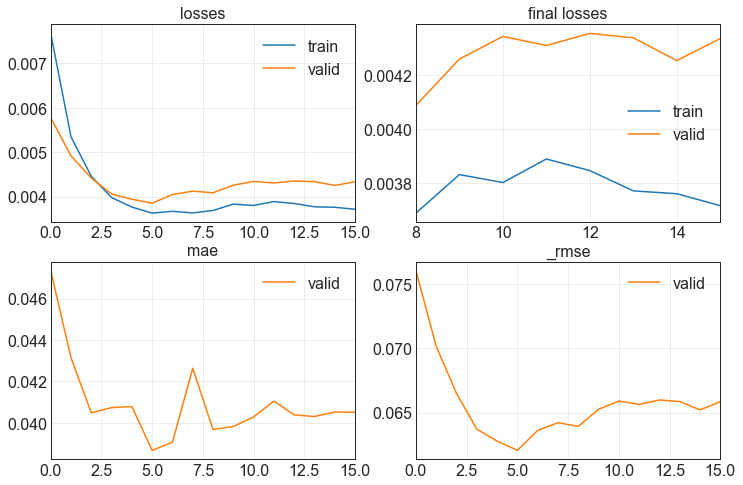

45.76876974105835                                                                                                      
[0.003715837374329567, 0.004334152210503817, 0.04051077738404274, 0.06583427637815475]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 10%|████                                     | 10/100 [26:48<3:20:36, 133.74s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 32: early stopping                                                                          
 10%|████                                     | 10/100 [28:31<3:20:36, 133.74s/trial, best loss: 0.0031187108252197504]

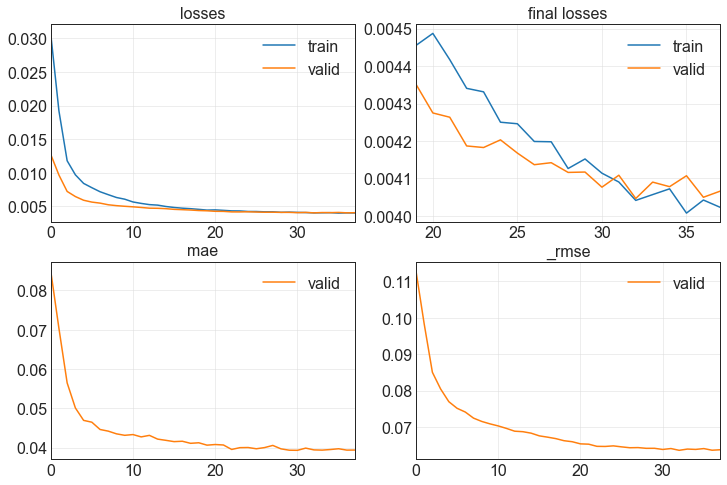

104.39563274383545                                                                                                     
[0.004022835288196802, 0.00406629079952836, 0.03939870744943619, 0.06376747041940689]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 11%|████▌                                    | 11/100 [28:37<3:07:31, 126.42s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 0: early stopping                                                                           
 11%|████▌                                    | 11/100 [29:10<3:07:31, 126.42s/trial, best loss: 0.0031187108252197504]

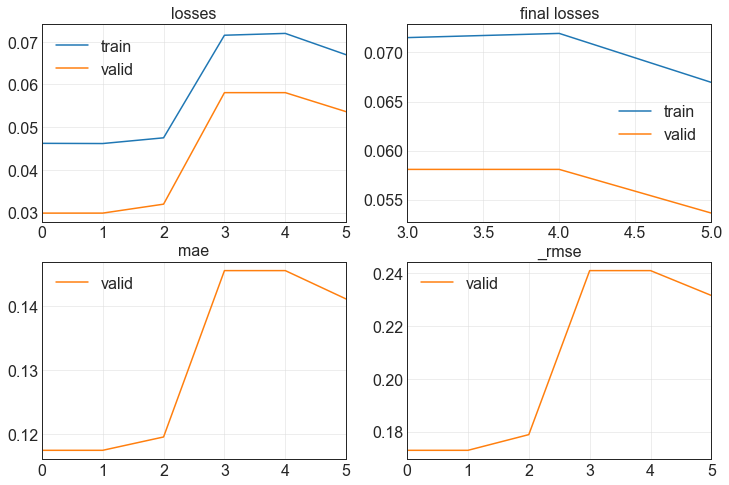

33.36546039581299                                                                                                      
[0.0669483095407486, 0.05362532287836075, 0.1411411613225937, 0.23157145082950592]                                     
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 12%|█████                                     | 12/100 [29:15<2:26:37, 99.97s/trial, best loss: 0.0031187108252197504]

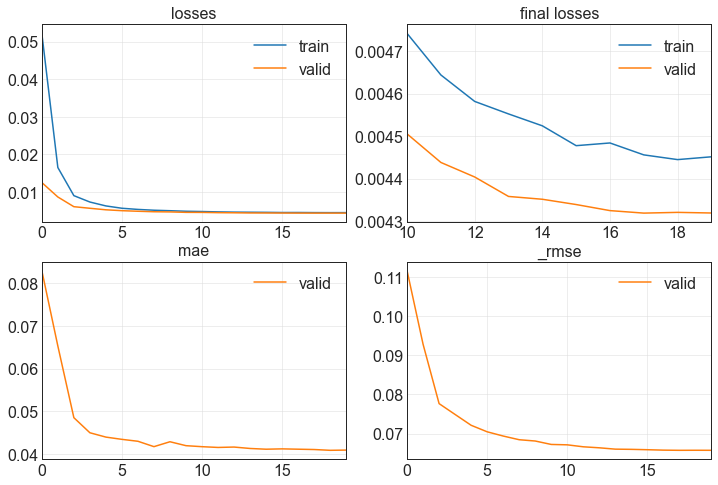

28.991499423980713                                                                                                     
[0.004451376385986805, 0.004319334868341684, 0.04088976979255676, 0.06572165340185165]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 13%|█████▍                                    | 13/100 [29:49<1:56:09, 80.11s/trial, best loss: 0.0031187108252197504]

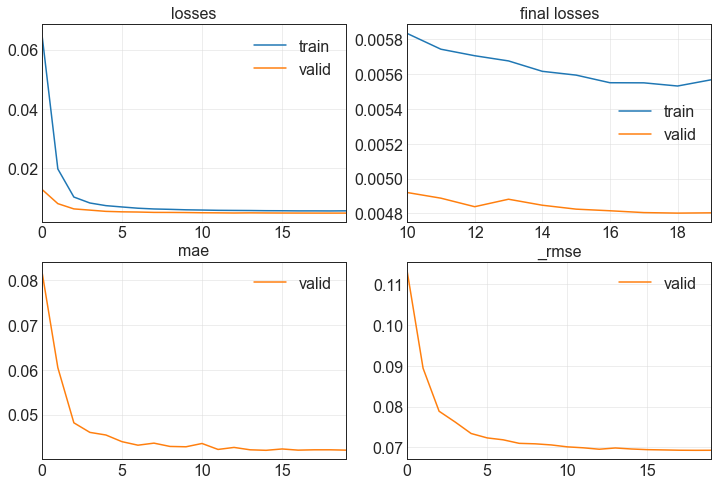

29.512861490249634                                                                                                     
[0.005568266846239567, 0.004803716670721769, 0.042075734585523605, 0.06930885463953018]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 14%|█████▉                                    | 14/100 [30:23<1:35:07, 66.36s/trial, best loss: 0.0031187108252197504]

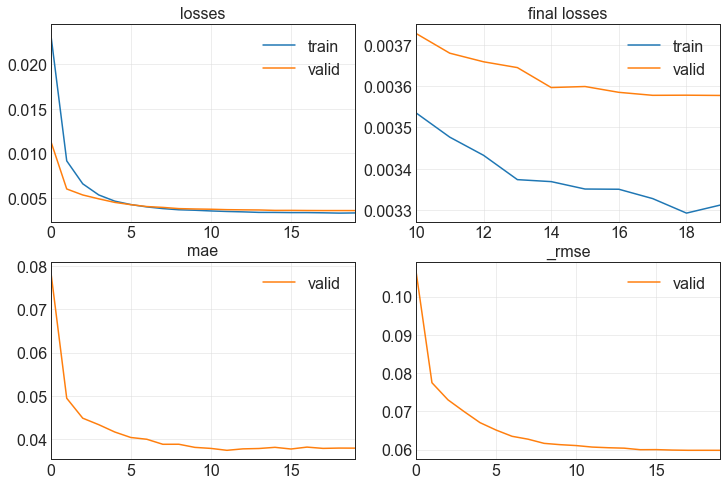

30.8340904712677                                                                                                       
[0.003312110435217619, 0.00357735063880682, 0.037924110889434814, 0.059810955077409744]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 15%|██████▎                                   | 15/100 [30:59<1:20:58, 57.15s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 4: early stopping                                                                           
 15%|██████▎                                   | 15/100 [31:22<1:20:58, 57.15s/trial, best loss: 0.0031187108252197504]

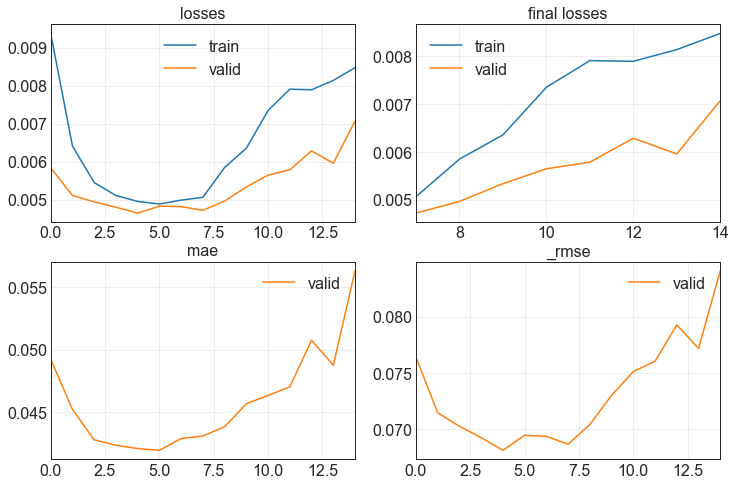

23.706954956054688                                                                                                     
[0.008475271984934807, 0.007069259881973267, 0.056348785758018494, 0.08407889306545258]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 16%|██████▋                                   | 16/100 [31:28<1:08:04, 48.63s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 24: early stopping                                                                          
 16%|██████▋                                   | 16/100 [36:41<1:08:04, 48.63s/trial, best loss: 0.0031187108252197504]

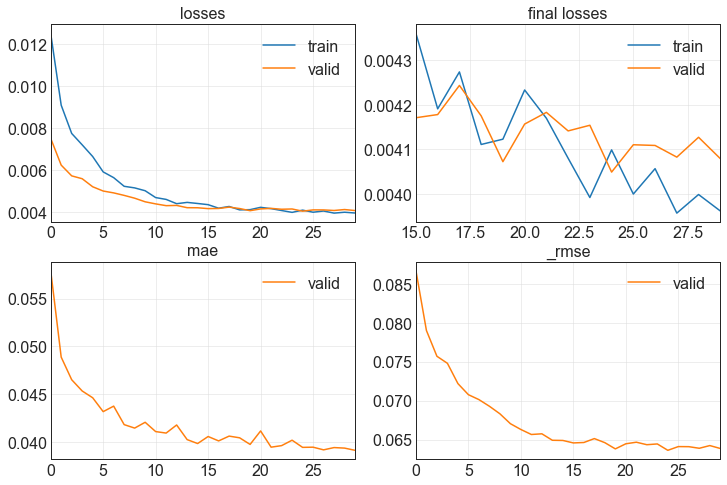

313.40031695365906                                                                                                     
[0.003962449263781309, 0.004079494625329971, 0.03910846635699272, 0.06387091428041458]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 17%|██████▉                                  | 17/100 [36:46<2:59:14, 129.58s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 7: early stopping                                                                           
 17%|██████▉                                  | 17/100 [39:55<2:59:14, 129.58s/trial, best loss: 0.0031187108252197504]

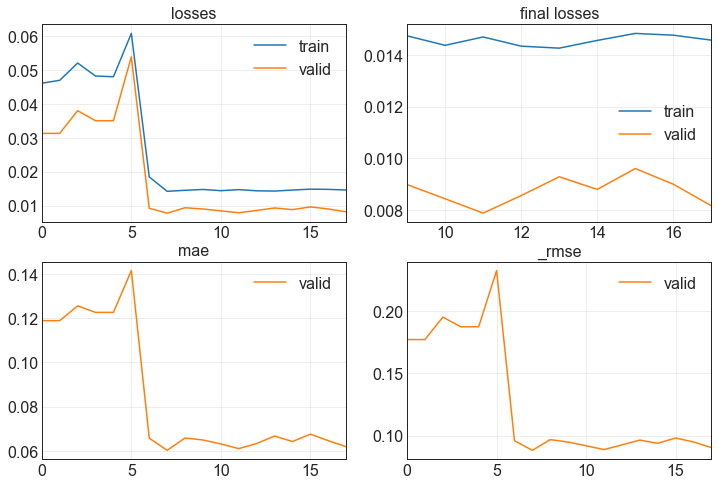

189.70694398880005                                                                                                     
[0.014582854695618153, 0.00815424881875515, 0.061810340732336044, 0.09030090272426605]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 18%|███████▍                                 | 18/100 [40:01<3:23:47, 149.12s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 0: early stopping                                                                           
 18%|███████▍                                 | 18/100 [40:16<3:23:47, 149.12s/trial, best loss: 0.0031187108252197504]

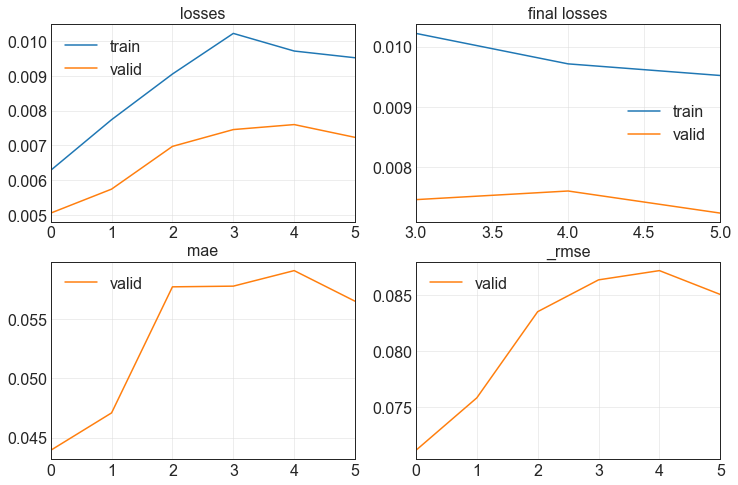

16.18485188484192                                                                                                      
[0.009519814513623714, 0.007232998963445425, 0.0564991720020771, 0.08504703640937805]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 19%|███████▊                                 | 19/100 [40:21<2:29:23, 110.66s/trial, best loss: 0.0031187108252197504]

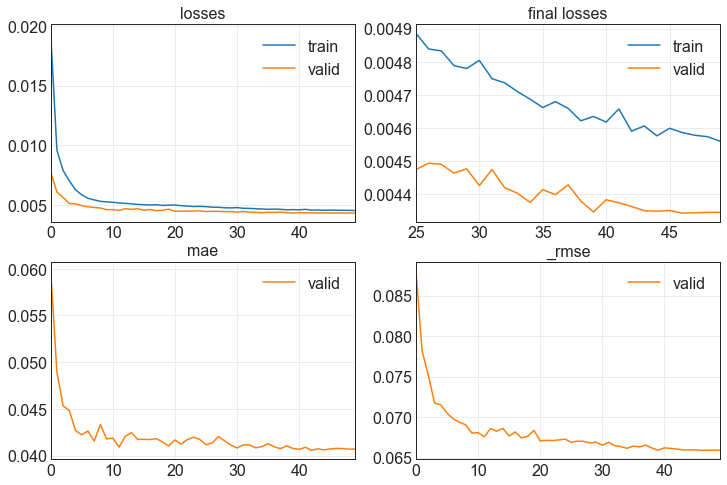

69.69060349464417                                                                                                      
[0.004560219589620829, 0.004345941822975874, 0.04068824276328087, 0.06592375040054321]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 20%|████████▍                                 | 20/100 [41:36<2:13:01, 99.77s/trial, best loss: 0.0031187108252197504]

No improvement since epoch 44: early stopping                                                                          
 20%|████████▍                                 | 20/100 [50:23<2:13:01, 99.77s/trial, best loss: 0.0031187108252197504]

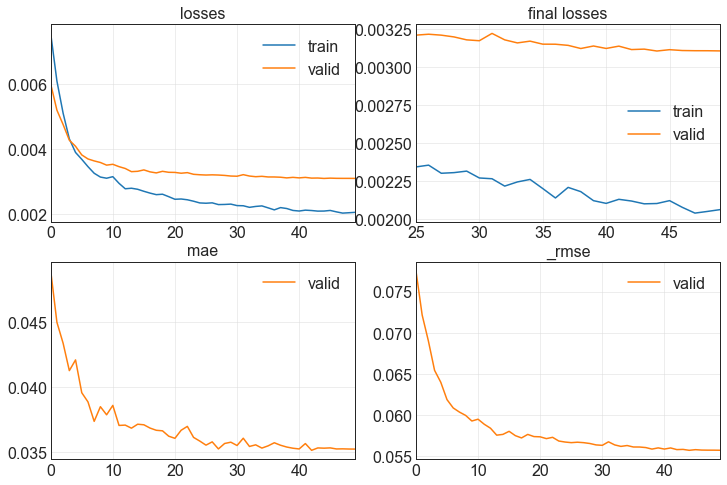

527.8364636898041                                                                                                      
[0.0020602657459676266, 0.0031053617130964994, 0.03520998731255531, 0.05572578310966492]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 21%|████████▌                                | 21/100 [50:29<5:02:18, 229.61s/trial, best loss: 0.0031053617130964994]

No improvement since epoch 22: early stopping                                                                          
 21%|████████▌                                | 21/100 [55:21<5:02:18, 229.61s/trial, best loss: 0.0031053617130964994]

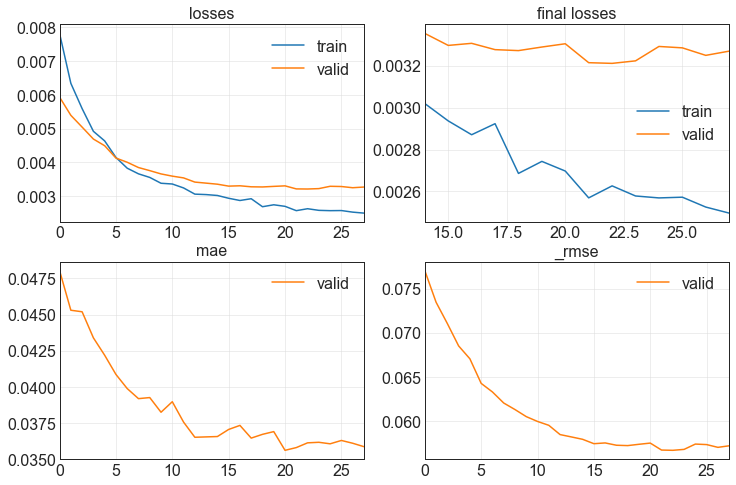

292.91011571884155                                                                                                     
[0.002496918197721243, 0.00326934433542192, 0.0358603373169899, 0.05717817693948746]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 22%|█████████                                | 22/100 [55:27<5:25:13, 250.18s/trial, best loss: 0.0031053617130964994]

No improvement since epoch 3: early stopping                                                                           
 22%|█████████                                | 22/100 [56:19<5:25:13, 250.18s/trial, best loss: 0.0031053617130964994]

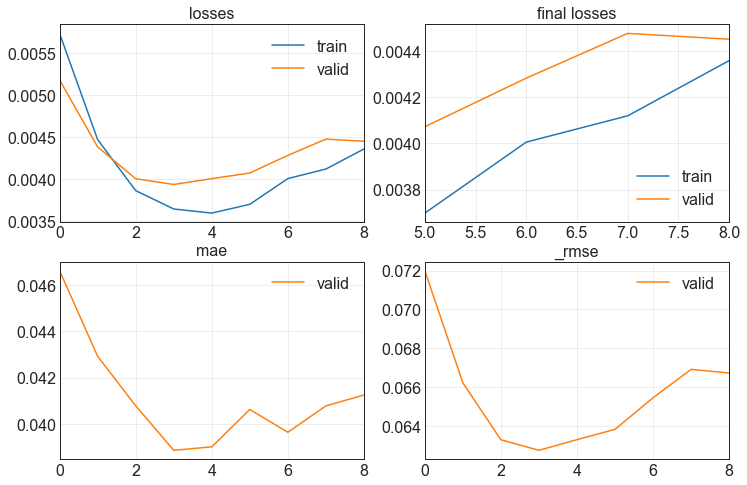

52.43873834609985                                                                                                      
[0.004359039012342691, 0.004451661836355925, 0.041244007647037506, 0.06672078371047974]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 23%|█████████▍                               | 23/100 [56:25<4:06:57, 192.44s/trial, best loss: 0.0031053617130964994]

No improvement since epoch 37: early stopping                                                                          
 23%|████████▉                              | 23/100 [1:00:24<4:06:57, 192.44s/trial, best loss: 0.0031053617130964994]

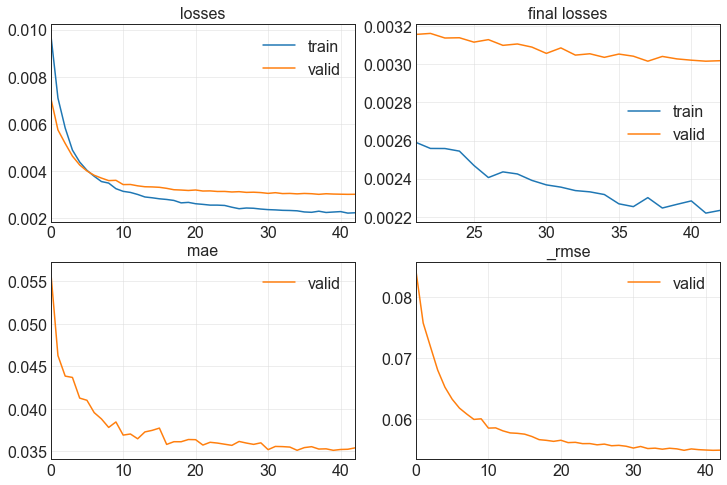

239.5119514465332                                                                                                      
[0.0022340051364153624, 0.0030182728078216314, 0.035398293286561966, 0.05493880808353424]                              
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 24%|█████████▎                             | 24/100 [1:00:29<4:23:33, 208.08s/trial, best loss: 0.0030182728078216314]

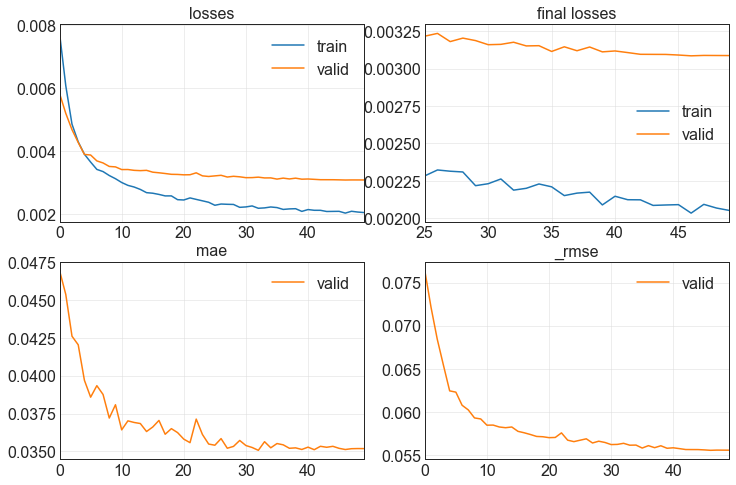

506.0421681404114                                                                                                      
[0.0020525511354207993, 0.003087829565629363, 0.035178132355213165, 0.055568236857652664]                              
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 25%|█████████▊                             | 25/100 [1:09:00<6:13:39, 298.92s/trial, best loss: 0.0030182728078216314]

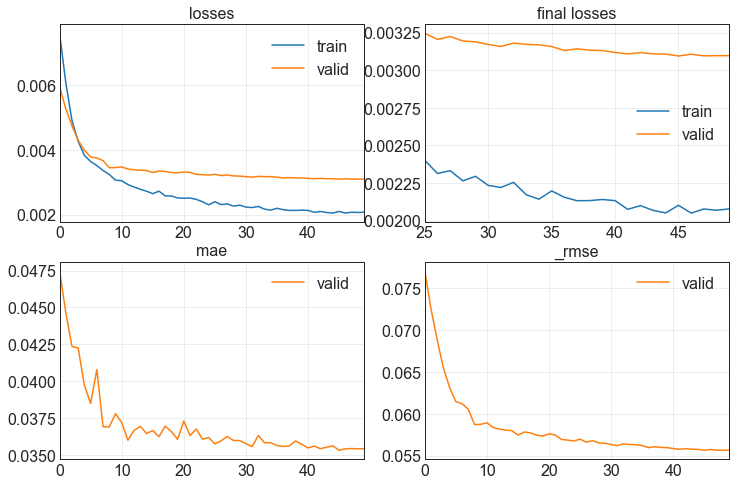

515.1359062194824                                                                                                      
[0.0020774018485099077, 0.0030966599006205797, 0.03542895242571831, 0.055647652596235275]                              
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 26%|██████████▏                            | 26/100 [1:17:40<7:30:28, 365.25s/trial, best loss: 0.0030182728078216314]

No improvement since epoch 4: early stopping                                                                           
 26%|██████████▏                            | 26/100 [1:18:33<7:30:28, 365.25s/trial, best loss: 0.0030182728078216314]

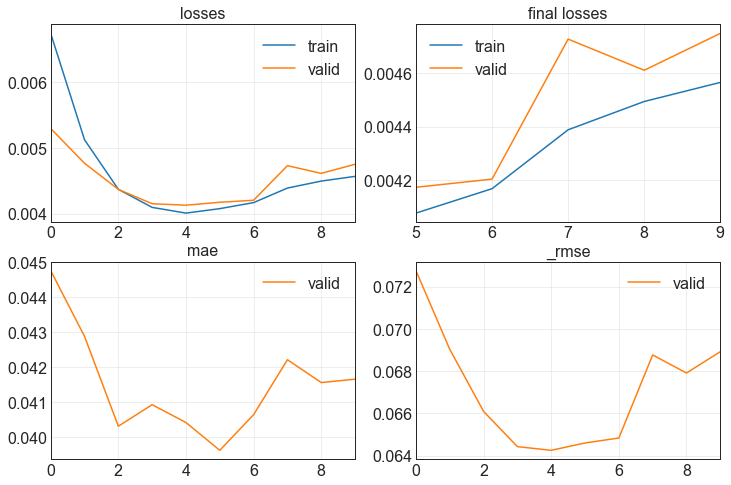

53.74709916114807                                                                                                      
[0.004566103685647249, 0.004750007763504982, 0.04165392741560936, 0.06892029941082001]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 27%|██████████▌                            | 27/100 [1:18:39<5:32:29, 273.28s/trial, best loss: 0.0030182728078216314]

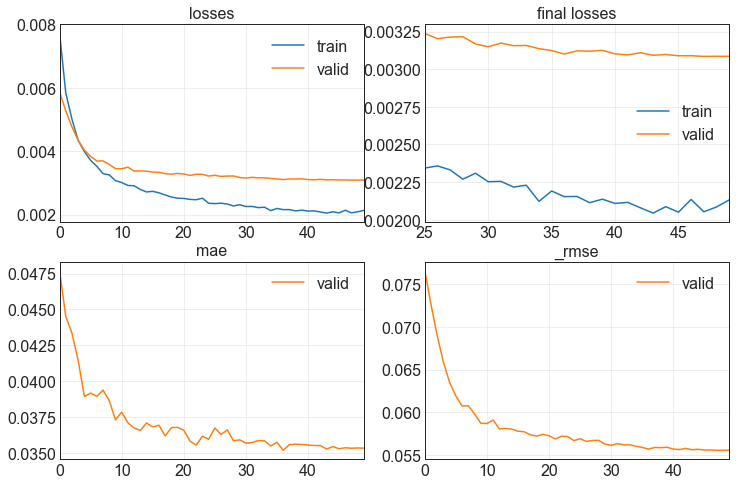

520.4627344608307                                                                                                      
[0.002131739165633917, 0.003086153417825699, 0.03533780202269554, 0.055553141981363297]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 28%|██████████▉                            | 28/100 [1:27:24<6:58:40, 348.89s/trial, best loss: 0.0030182728078216314]

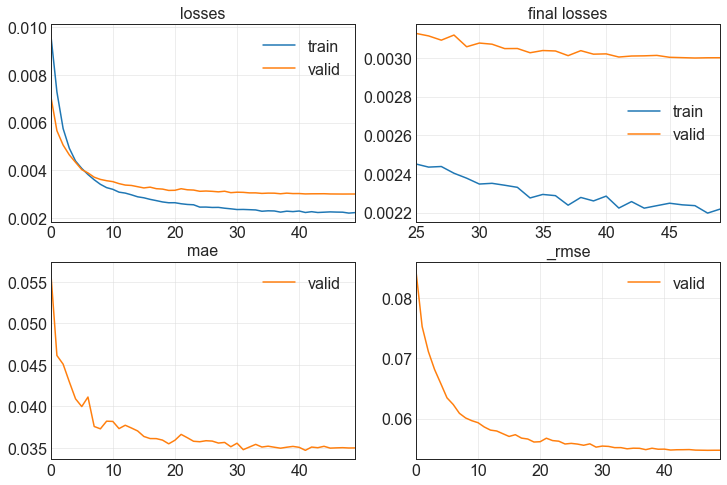

273.7080285549164                                                                                                      
[0.0022189095616340637, 0.0030005057342350483, 0.03500423580408096, 0.0547768659889698]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 29%|███████████▎                           | 29/100 [1:32:03<6:27:57, 327.85s/trial, best loss: 0.0030005057342350483]

No improvement since epoch 38: early stopping                                                                          
 29%|███████████▎                           | 29/100 [1:35:58<6:27:57, 327.85s/trial, best loss: 0.0030005057342350483]

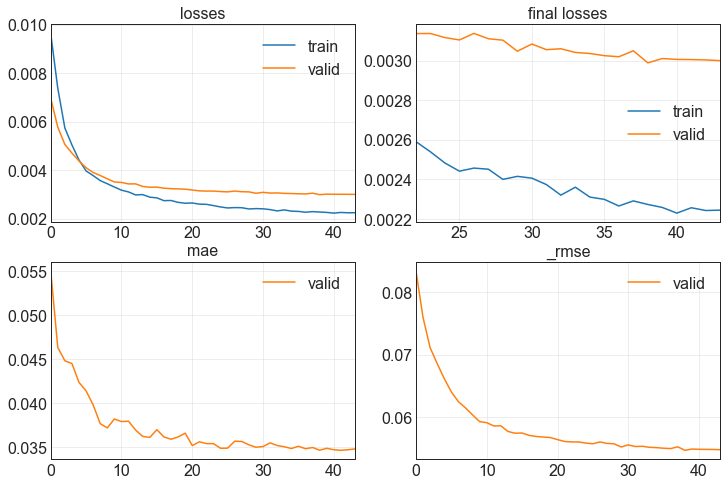

236.1390368938446                                                                                                      
[0.002243473893031478, 0.0029997448436915874, 0.034828417003154755, 0.05476992577314377]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 30%|███████████▋                           | 30/100 [1:36:03<5:52:03, 301.76s/trial, best loss: 0.0029997448436915874]

No improvement since epoch 31: early stopping                                                                          
 30%|███████████▋                           | 30/100 [1:39:24<5:52:03, 301.76s/trial, best loss: 0.0029997448436915874]

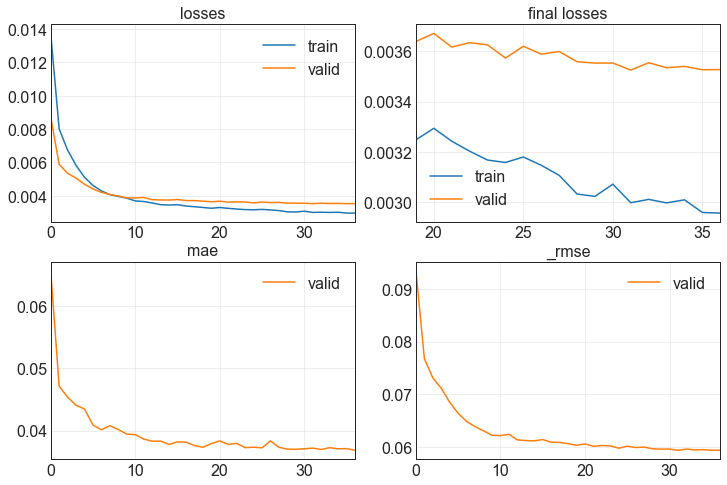

200.72792196273804                                                                                                     
[0.002957763848826289, 0.0035273146349936724, 0.036838024854660034, 0.05939119681715965]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 31%|████████████                           | 31/100 [1:39:29<5:13:49, 272.89s/trial, best loss: 0.0029997448436915874]

No improvement since epoch 42: early stopping                                                                          
 31%|████████████                           | 31/100 [1:43:53<5:13:49, 272.89s/trial, best loss: 0.0029997448436915874]

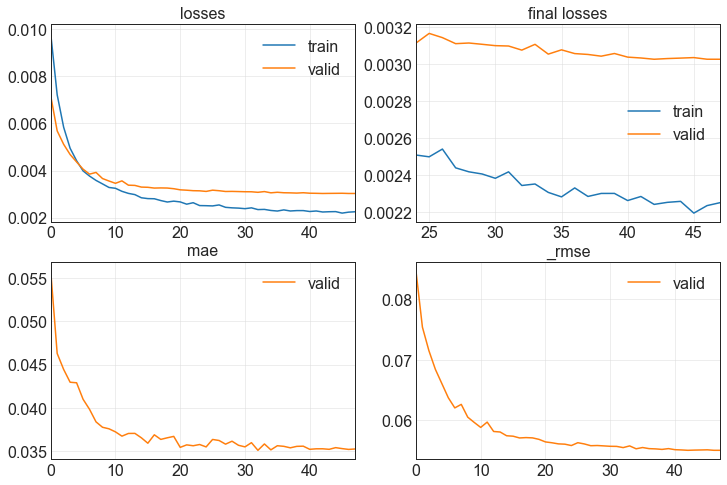

263.9788191318512                                                                                                      
[0.0022496948949992657, 0.003026725258678198, 0.03523597866296768, 0.0550156868994236]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 32%|████████████▍                          | 32/100 [1:43:58<5:07:54, 271.68s/trial, best loss: 0.0029997448436915874]

No improvement since epoch 3: early stopping                                                                           
 32%|████████████▍                          | 32/100 [1:44:45<5:07:54, 271.68s/trial, best loss: 0.0029997448436915874]

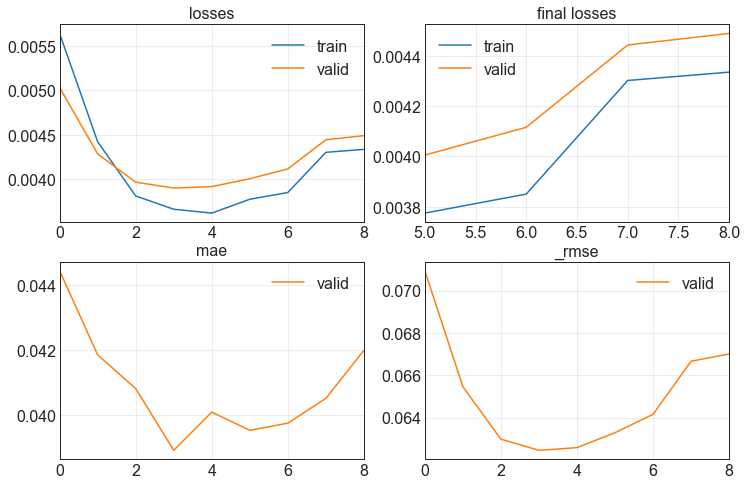

48.06298899650574                                                                                                      
[0.004335862118750811, 0.004490105900913477, 0.04200104624032974, 0.06700826436281204]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 33%|████████████▊                          | 33/100 [1:44:51<3:50:04, 206.03s/trial, best loss: 0.0029997448436915874]

No improvement since epoch 43: early stopping                                                                          
 33%|████████████▊                          | 33/100 [1:49:08<3:50:04, 206.03s/trial, best loss: 0.0029997448436915874]

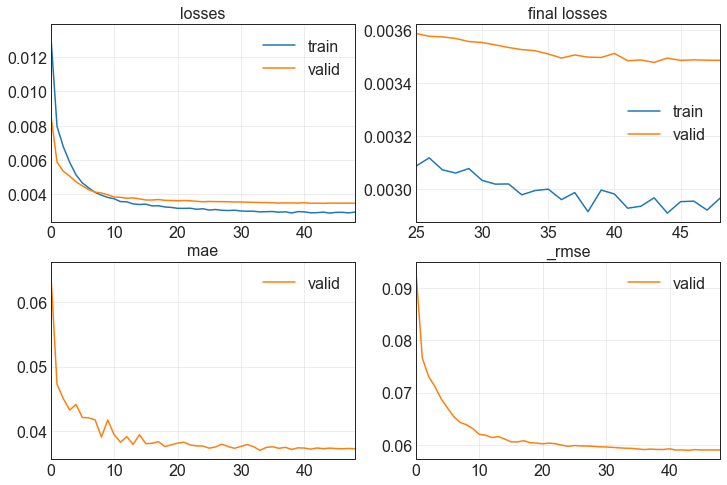

258.1881010532379                                                                                                      
[0.0029652188532054424, 0.0034864037297666073, 0.037210315465927124, 0.059045784175395966]                             
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 34%|█████████████▎                         | 34/100 [1:49:14<4:05:24, 223.09s/trial, best loss: 0.0029997448436915874]

No improvement since epoch 38: early stopping                                                                          
 34%|█████████████▎                         | 34/100 [1:53:13<4:05:24, 223.09s/trial, best loss: 0.0029997448436915874]

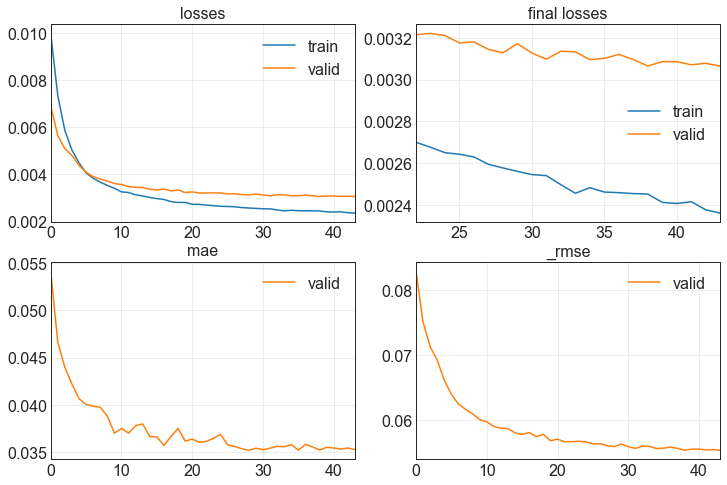

239.67840909957886                                                                                                     
[0.0023612596560269594, 0.0030645744409412146, 0.03526084125041962, 0.05535859987139702]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 35%|█████████████▋                         | 35/100 [1:53:18<4:08:39, 229.53s/trial, best loss: 0.0029997448436915874]

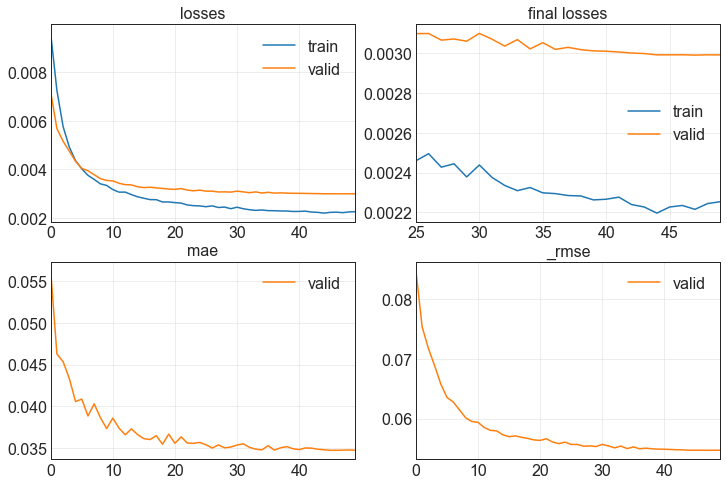

277.5807912349701                                                                                                      
[0.00225332984700799, 0.0029915052000433207, 0.0347590334713459, 0.05469465255737305]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 36%|██████████████                         | 36/100 [1:58:01<4:21:51, 245.49s/trial, best loss: 0.0029915052000433207]

No improvement since epoch 0: early stopping                                                                           
 36%|██████████████                         | 36/100 [1:58:31<4:21:51, 245.49s/trial, best loss: 0.0029915052000433207]

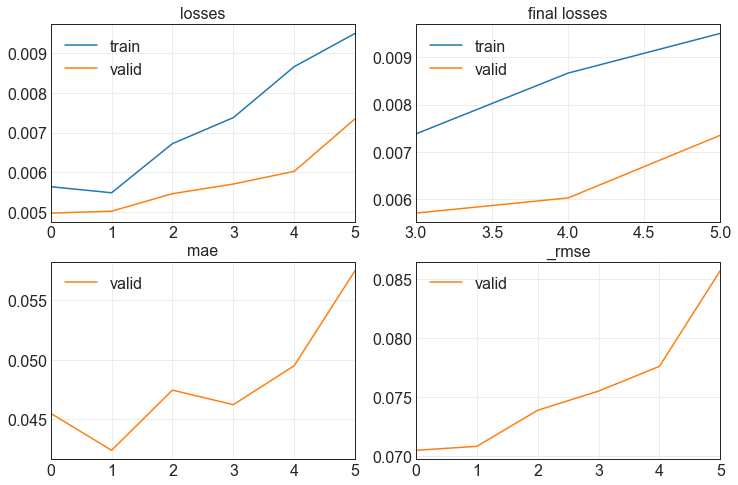

30.537882566452026                                                                                                     
[0.009506977163255215, 0.007350664120167494, 0.05751219019293785, 0.08573600649833679]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 37%|██████████████▍                        | 37/100 [1:58:36<3:11:33, 182.44s/trial, best loss: 0.0029915052000433207]

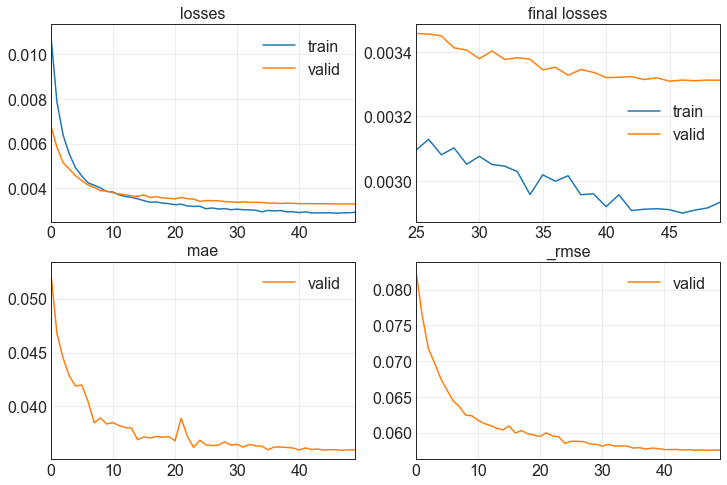

279.58993315696716                                                                                                     
[0.0029343427158892155, 0.003312251530587673, 0.03597249090671539, 0.05755215883255005]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 38%|██████████████▊                        | 38/100 [2:03:21<3:40:06, 213.01s/trial, best loss: 0.0029915052000433207]

No improvement since epoch 33: early stopping                                                                          
 38%|██████████████▊                        | 38/100 [2:06:55<3:40:06, 213.01s/trial, best loss: 0.0029915052000433207]

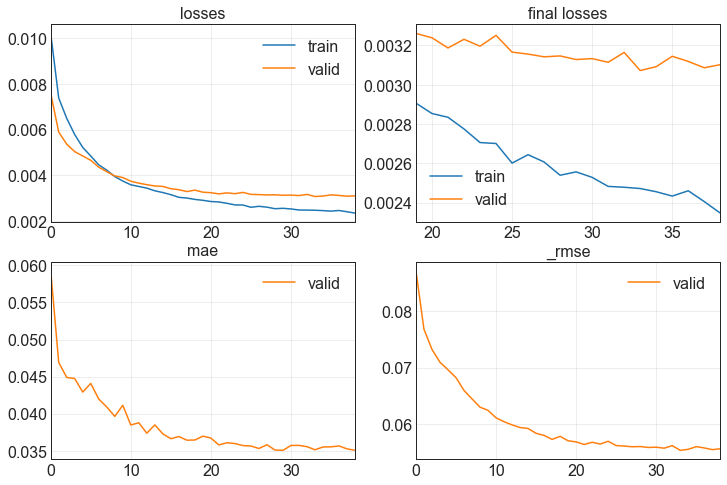

214.9017641544342                                                                                                      
[0.0023467233404517174, 0.0031022103503346443, 0.035061564296483994, 0.0556974783539772]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 39%|███████████████▏                       | 39/100 [2:07:00<3:38:36, 215.03s/trial, best loss: 0.0029915052000433207]

No improvement since epoch 5: early stopping                                                                           
 39%|███████████████▏                       | 39/100 [2:07:33<3:38:36, 215.03s/trial, best loss: 0.0029915052000433207]

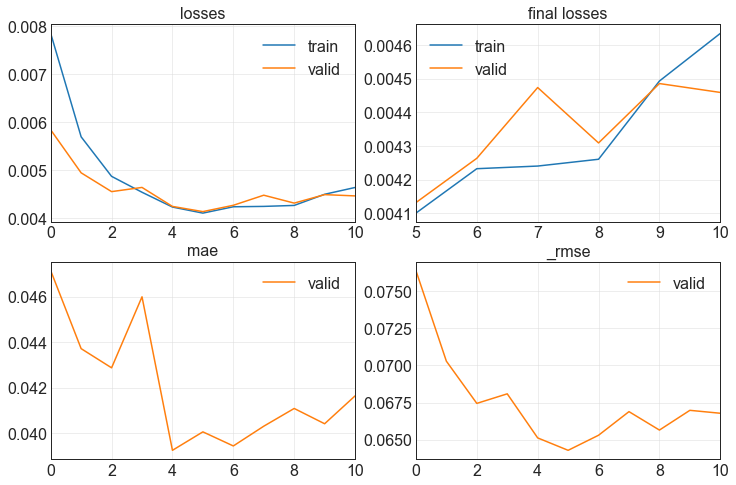

32.678292989730835                                                                                                     
[0.004634584300220013, 0.004459062125533819, 0.04163314029574394, 0.06677620112895966]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 40%|███████████████▌                       | 40/100 [2:07:38<2:41:47, 161.78s/trial, best loss: 0.0029915052000433207]

No improvement since epoch 0: early stopping                                                                           
 40%|███████████████▌                       | 40/100 [2:08:11<2:41:47, 161.78s/trial, best loss: 0.0029915052000433207]

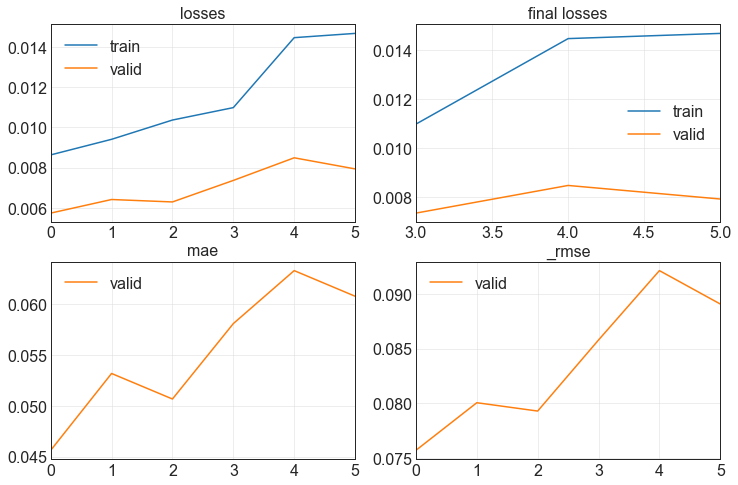

33.58302354812622                                                                                                      
[0.014680575579404831, 0.007934262976050377, 0.06080362945795059, 0.08907448500394821]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 41%|███████████████▉                       | 41/100 [2:08:16<2:02:41, 124.77s/trial, best loss: 0.0029915052000433207]

No improvement since epoch 87: early stopping                                                                          
 41%|███████████████▉                       | 41/100 [2:13:02<2:02:41, 124.77s/trial, best loss: 0.0029915052000433207]

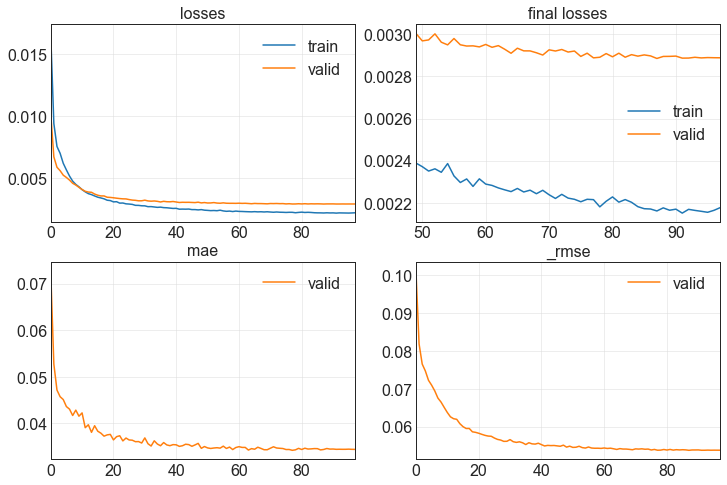

286.32339310646057                                                                                                     
[0.0021774987690150738, 0.0028882252518087626, 0.034432750195264816, 0.053742215037345886]                             
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 42%|████████████████▍                      | 42/100 [2:13:07<2:48:50, 174.67s/trial, best loss: 0.0028882252518087626]

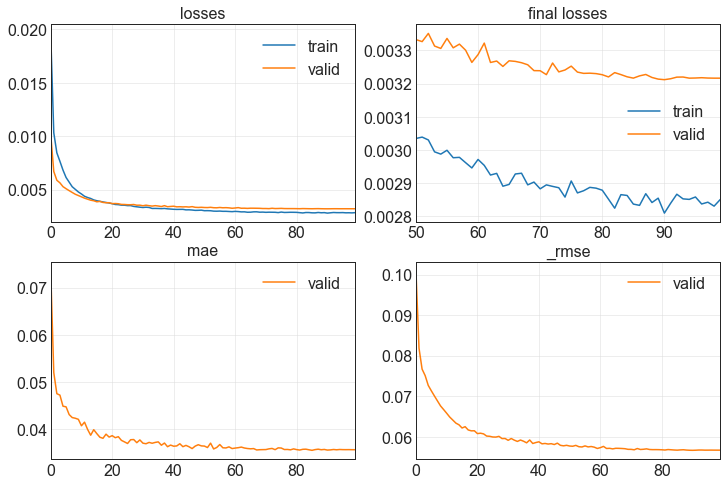

287.11953115463257                                                                                                     
[0.0028507187962532043, 0.003216383745893836, 0.035714250057935715, 0.05671317130327225]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 43%|████████████████▊                      | 43/100 [2:18:00<3:19:21, 209.86s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 9: early stopping                                                                           
 43%|████████████████▊                      | 43/100 [2:18:58<3:19:21, 209.86s/trial, best loss: 0.0028882252518087626]

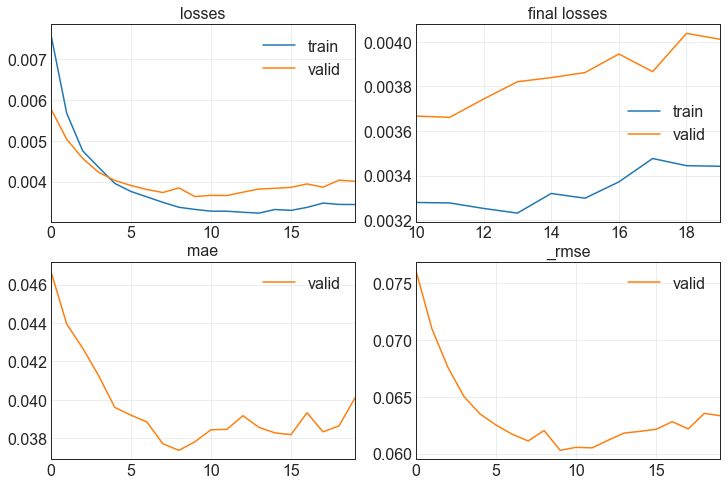

58.75184154510498                                                                                                      
[0.00344223459251225, 0.0040113069117069244, 0.040104880928993225, 0.0633348822593689]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 44%|█████████████████▏                     | 44/100 [2:19:03<2:34:58, 166.05s/trial, best loss: 0.0028882252518087626]

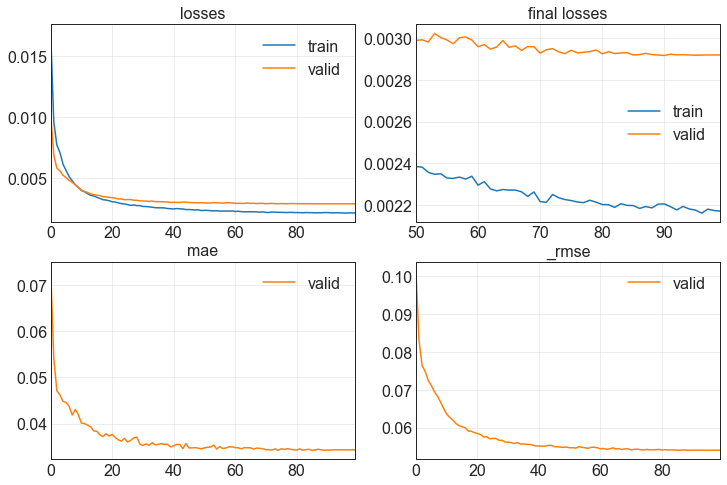

276.90948605537415                                                                                                     
[0.0021704717073589563, 0.0029196981340646744, 0.03436756879091263, 0.05403423681855202]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 45%|█████████████████▌                     | 45/100 [2:23:45<3:04:00, 200.74s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 3: early stopping                                                                           
 45%|█████████████████▌                     | 45/100 [2:24:25<3:04:00, 200.74s/trial, best loss: 0.0028882252518087626]

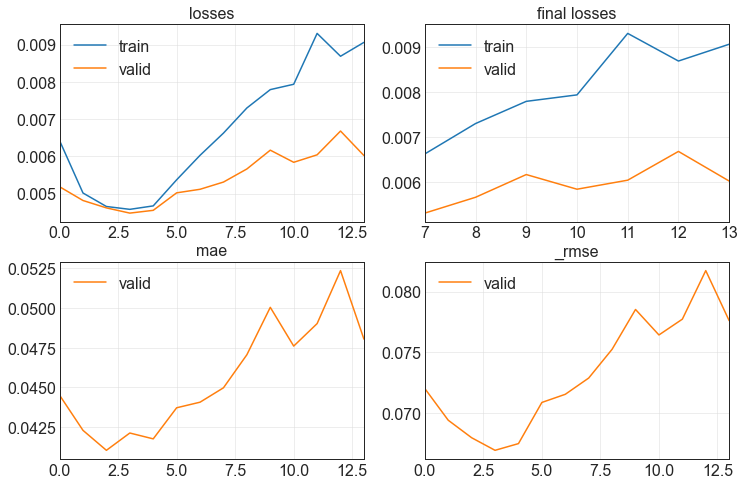

40.44416880607605                                                                                                      
[0.009057705290615559, 0.006022043060511351, 0.04804306849837303, 0.0776018276810646]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 46%|█████████████████▉                     | 46/100 [2:24:30<2:18:41, 154.10s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 60: early stopping                                                                          
 46%|█████████████████▉                     | 46/100 [2:27:52<2:18:41, 154.10s/trial, best loss: 0.0028882252518087626]

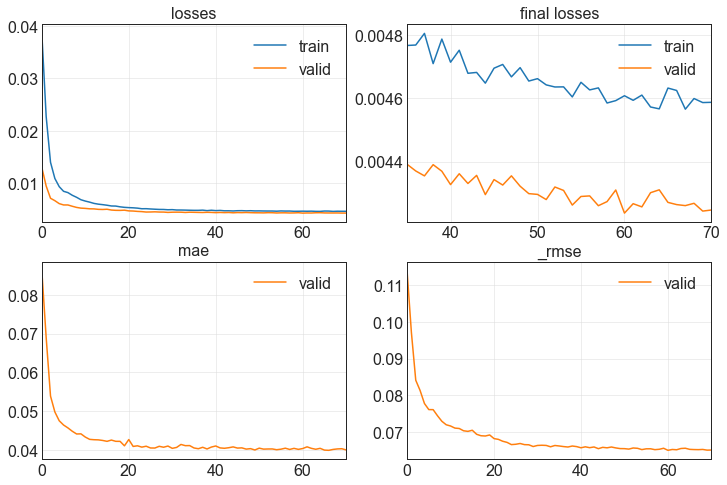

202.38460111618042                                                                                                     
[0.004587189760059118, 0.004247058182954788, 0.040003906935453415, 0.06516945362091064]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 47%|██████████████████▎                    | 47/100 [2:27:58<2:30:14, 170.08s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 72: early stopping                                                                          
 47%|██████████████████▎                    | 47/100 [2:31:56<2:30:14, 170.08s/trial, best loss: 0.0028882252518087626]

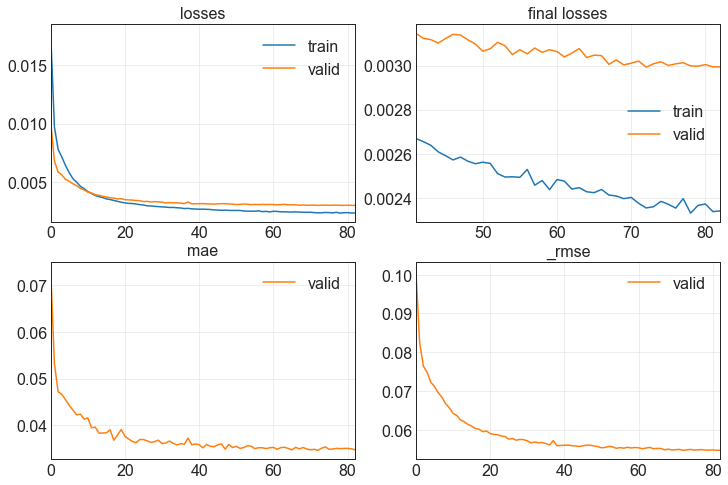

238.48111581802368                                                                                                     
[0.002341102110221982, 0.0029940344393253326, 0.034744810312986374, 0.054717767983675]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 48%|██████████████████▋                    | 48/100 [2:32:01<2:46:29, 192.10s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 4: early stopping                                                                           
 48%|██████████████████▋                    | 48/100 [2:32:44<2:46:29, 192.10s/trial, best loss: 0.0028882252518087626]

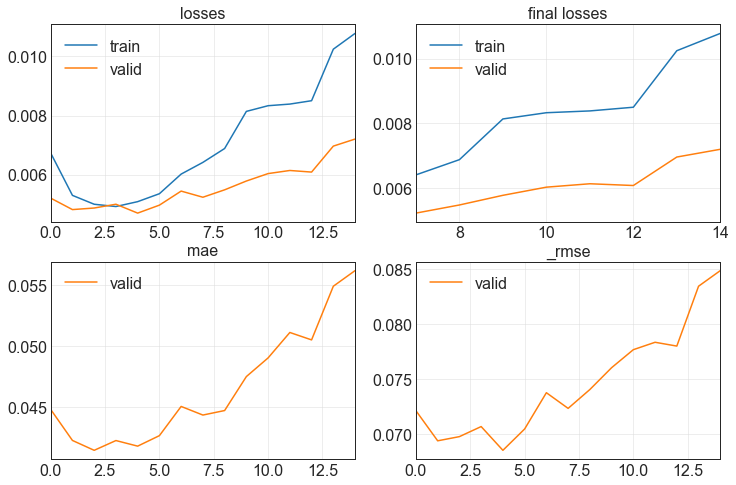

42.76466178894043                                                                                                      
[0.010781790129840374, 0.007201888132840395, 0.05618348717689514, 0.08486394584178925]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 49%|███████████████████                    | 49/100 [2:32:49<2:06:30, 148.83s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 81: early stopping                                                                          
 49%|███████████████████                    | 49/100 [2:37:12<2:06:30, 148.83s/trial, best loss: 0.0028882252518087626]

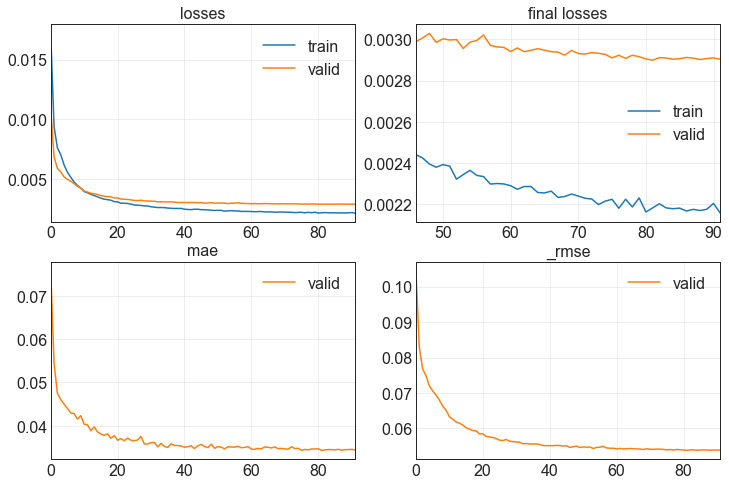

263.76679587364197                                                                                                     
[0.002157342853024602, 0.002903460757806897, 0.03442206233739853, 0.05388377234339714]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 50%|███████████████████▌                   | 50/100 [2:37:18<2:33:57, 184.75s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 8: early stopping                                                                           
 50%|███████████████████▌                   | 50/100 [2:38:13<2:33:57, 184.75s/trial, best loss: 0.0028882252518087626]

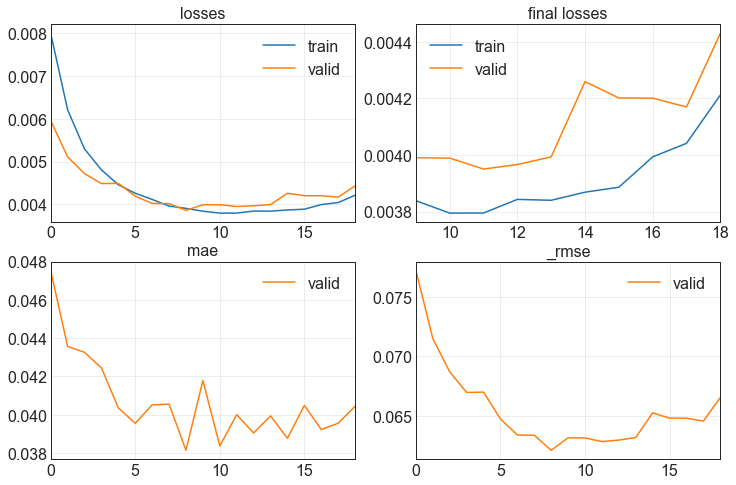

55.95098328590393                                                                                                      
[0.004211866296827793, 0.004429709166288376, 0.04044243320822716, 0.06655605882406235]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 51%|███████████████████▉                   | 51/100 [2:38:19<2:00:32, 147.61s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 40: early stopping                                                                          
 51%|███████████████████▉                   | 51/100 [2:40:34<2:00:32, 147.61s/trial, best loss: 0.0028882252518087626]

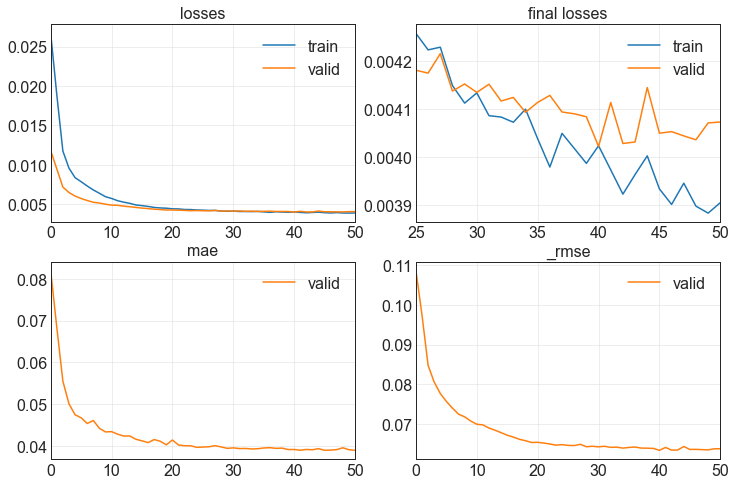

135.92578053474426                                                                                                     
[0.003904698882251978, 0.004072877578437328, 0.03891393914818764, 0.06381910294294357]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 52%|████████████████████▎                  | 52/100 [2:40:39<1:56:31, 145.65s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 3: early stopping                                                                           
 52%|████████████████████▎                  | 52/100 [2:41:16<1:56:31, 145.65s/trial, best loss: 0.0028882252518087626]

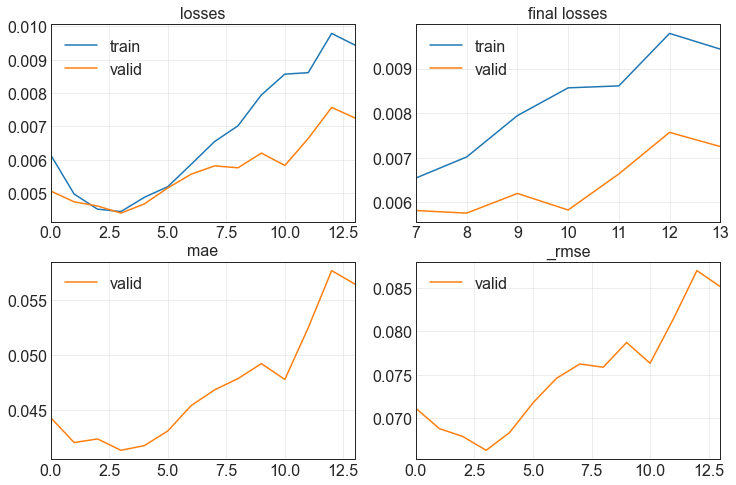

37.433557748794556                                                                                                     
[0.009438524022698402, 0.007252276409417391, 0.056486960500478745, 0.08516030013561249]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 53%|████████████████████▋                  | 53/100 [2:41:22<1:29:47, 114.63s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 85: early stopping                                                                          
 53%|████████████████████▋                  | 53/100 [2:43:49<1:29:47, 114.63s/trial, best loss: 0.0028882252518087626]

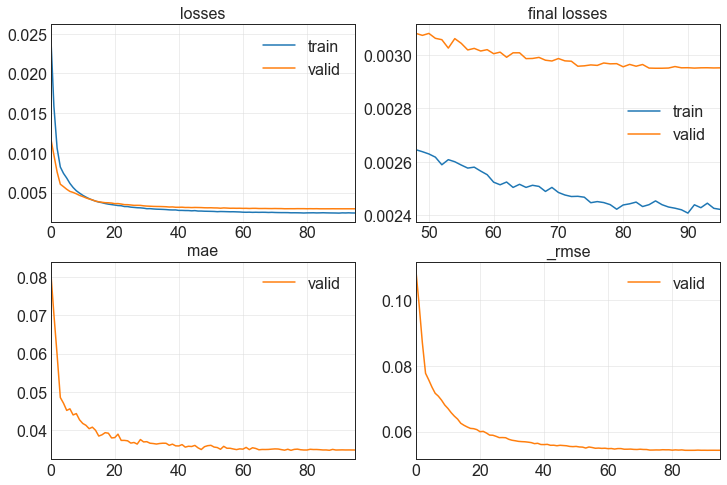

147.77360343933105                                                                                                     
[0.002421857789158821, 0.0029517130460590124, 0.03484884276986122, 0.05432967096567154]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 54%|█████████████████████                  | 54/100 [2:43:54<1:36:35, 125.99s/trial, best loss: 0.0028882252518087626]

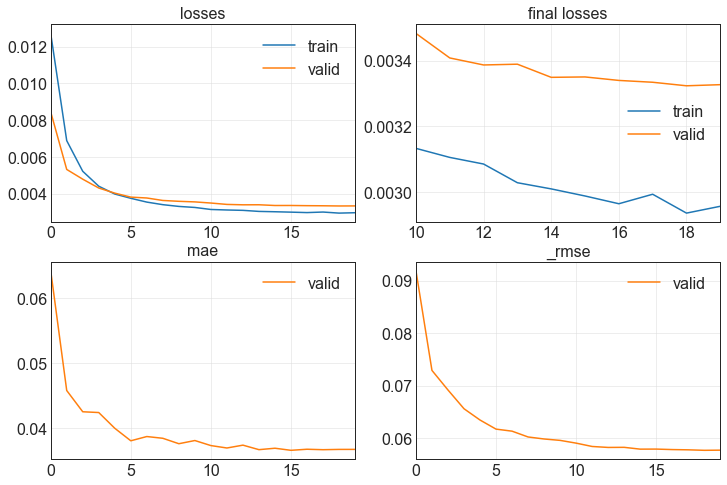

57.82347393035889                                                                                                      
[0.0029557794332504272, 0.003326650708913803, 0.036801885813474655, 0.05767713114619255]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 55%|█████████████████████▍                 | 55/100 [2:44:58<1:20:18, 107.08s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 10: early stopping                                                                          
 55%|█████████████████████▍                 | 55/100 [2:45:55<1:20:18, 107.08s/trial, best loss: 0.0028882252518087626]

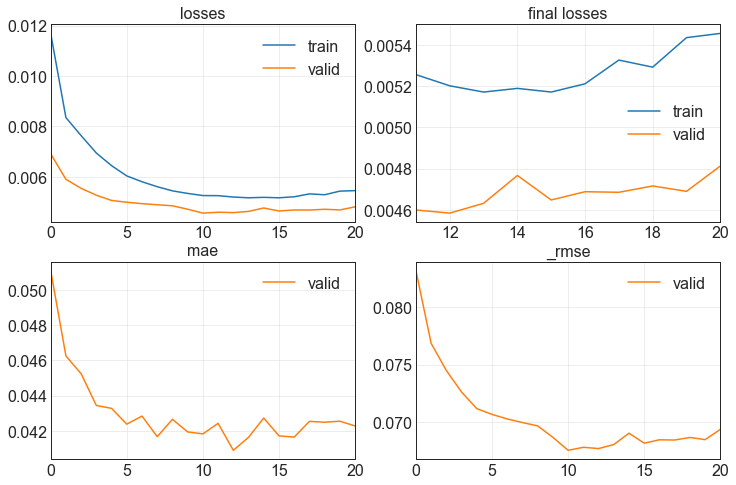

58.109978914260864                                                                                                     
[0.005455802194774151, 0.004812729544937611, 0.042280688881874084, 0.06937384605407715]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 56%|██████████████████████▍                 | 56/100 [2:46:01<1:08:55, 93.99s/trial, best loss: 0.0028882252518087626]

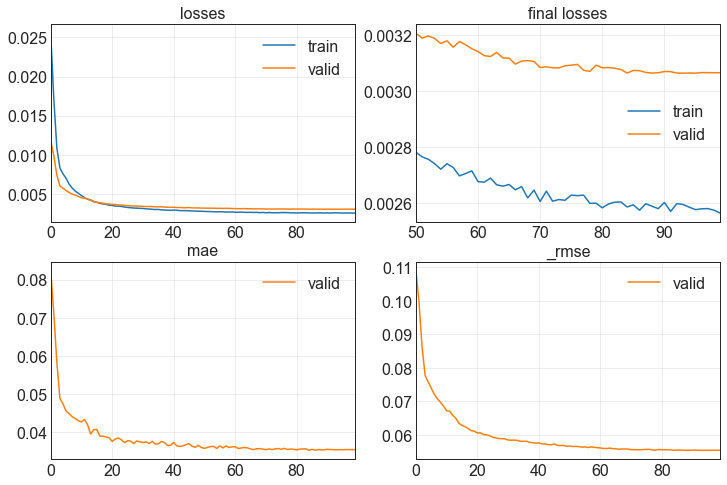

149.9414520263672                                                                                                      
[0.0025645969435572624, 0.003065240103751421, 0.03541925922036171, 0.05536460876464844]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 57%|██████████████████████▏                | 57/100 [2:48:35<1:20:26, 112.24s/trial, best loss: 0.0028882252518087626]

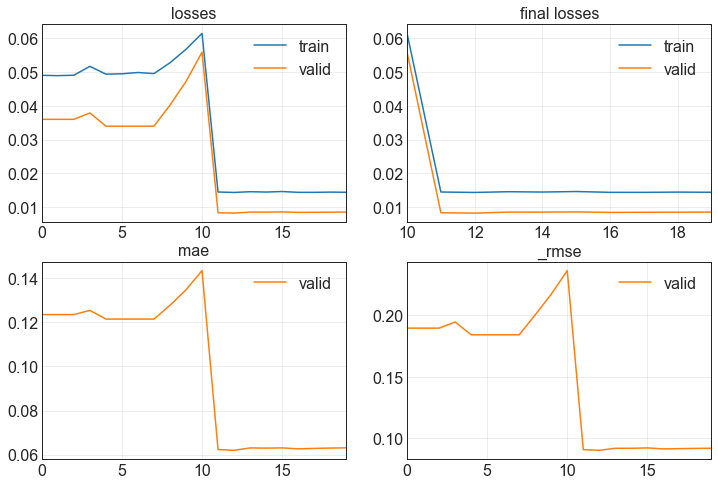

54.53628134727478                                                                                                      
[0.014337184838950634, 0.008457932621240616, 0.06311604380607605, 0.09196702390909195]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 58%|███████████████████████▏                | 58/100 [2:49:35<1:07:26, 96.35s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 72: early stopping                                                                          
 58%|███████████████████████▏                | 58/100 [2:53:27<1:07:26, 96.35s/trial, best loss: 0.0028882252518087626]

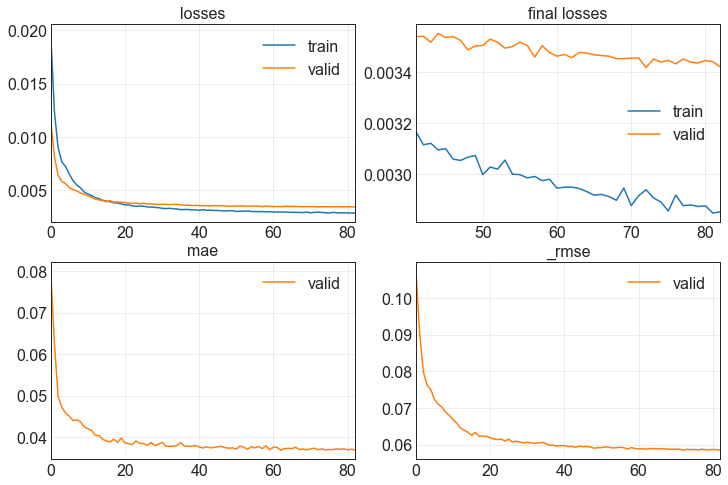

232.5895013809204                                                                                                      
[0.002852344186976552, 0.0034207915887236595, 0.03694502264261246, 0.058487534523010254]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 59%|███████████████████████                | 59/100 [2:53:32<1:34:46, 138.68s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 77: early stopping                                                                          
 59%|███████████████████████                | 59/100 [2:55:40<1:34:46, 138.68s/trial, best loss: 0.0028882252518087626]

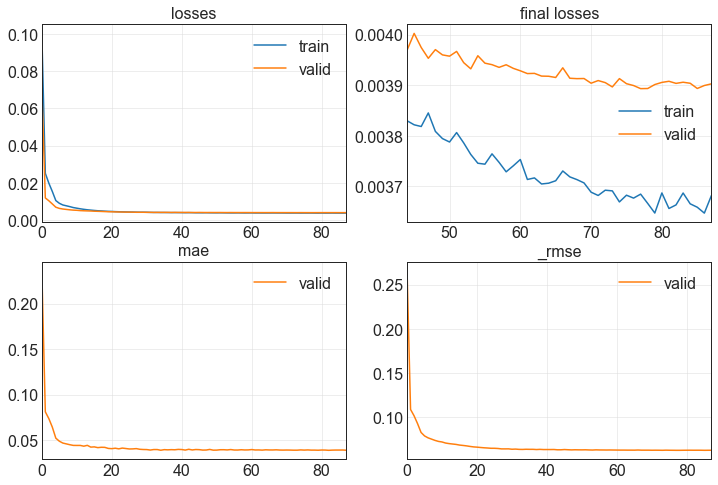

128.6779088973999                                                                                                      
[0.0036821900866925716, 0.0039028050377964973, 0.03895166516304016, 0.06247243285179138]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 60%|███████████████████████▍               | 60/100 [2:55:46<1:31:24, 137.12s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 10: early stopping                                                                          
 60%|███████████████████████▍               | 60/100 [2:56:46<1:31:24, 137.12s/trial, best loss: 0.0028882252518087626]

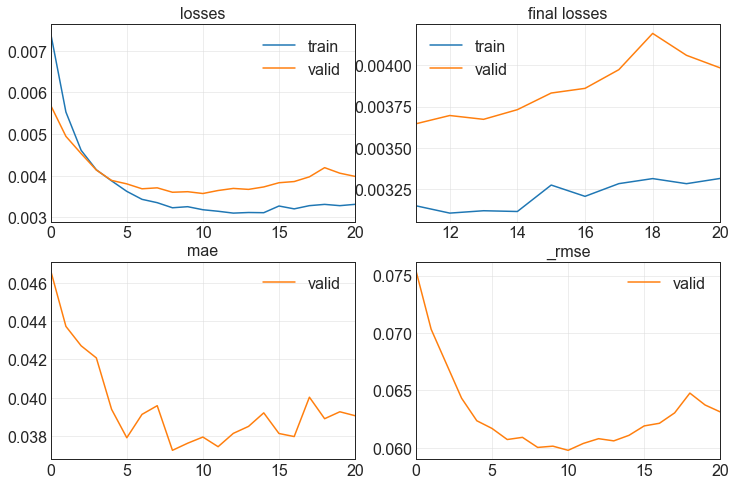

60.35743737220764                                                                                                      
[0.0033143211621791124, 0.003985049668699503, 0.03906160593032837, 0.06312724947929382]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 61%|███████████████████████▊               | 61/100 [2:56:51<1:15:09, 115.63s/trial, best loss: 0.0028882252518087626]

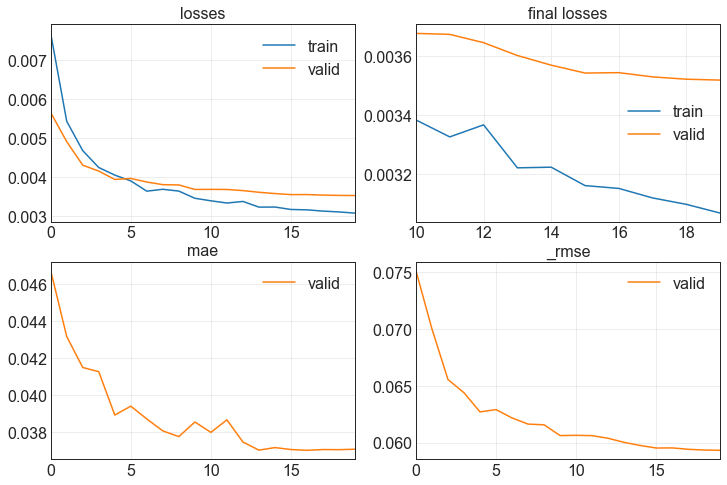

210.66402101516724                                                                                                     
[0.003067792858928442, 0.0035188577603548765, 0.0370931401848793, 0.05931996926665306]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 62%|████████████████████████▏              | 62/100 [3:00:27<1:32:12, 145.59s/trial, best loss: 0.0028882252518087626]

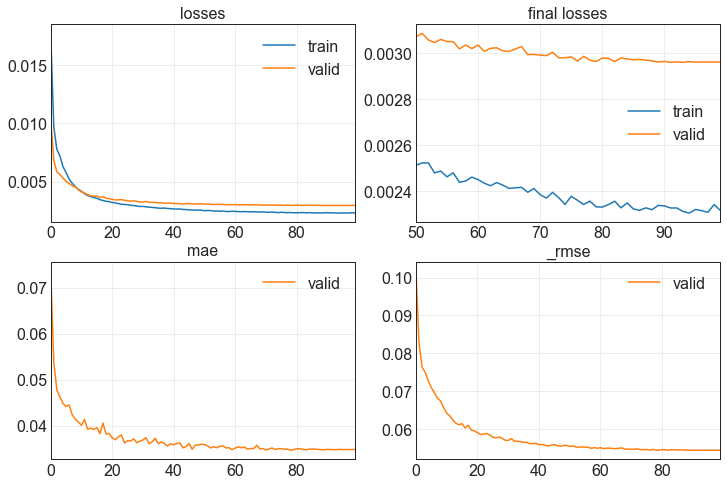

285.61572647094727                                                                                                     
[0.002315422287210822, 0.002961281454190612, 0.034788306802511215, 0.05441765859723091]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 63%|████████████████████████▌              | 63/100 [3:05:17<1:56:36, 189.09s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 3: early stopping                                                                           
 63%|████████████████████████▌              | 63/100 [3:05:55<1:56:36, 189.09s/trial, best loss: 0.0028882252518087626]

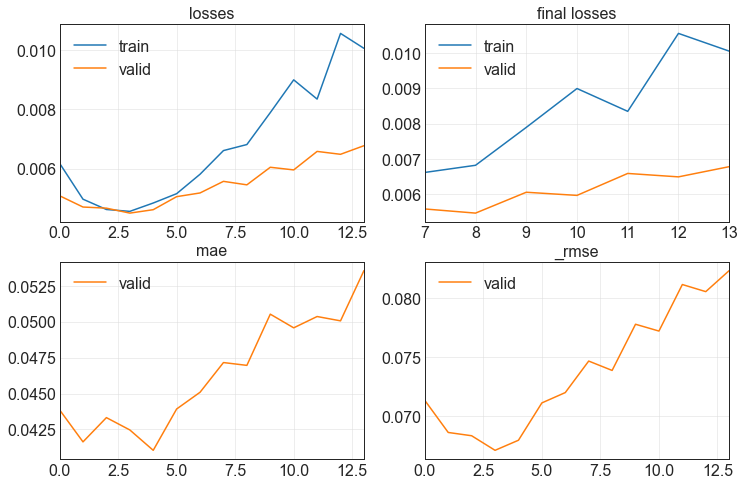

38.38113045692444                                                                                                      
[0.010062186047434807, 0.0067744129337370396, 0.05355583876371384, 0.08230681717395782]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 64%|████████████████████████▉              | 64/100 [3:06:01<1:27:11, 145.31s/trial, best loss: 0.0028882252518087626]

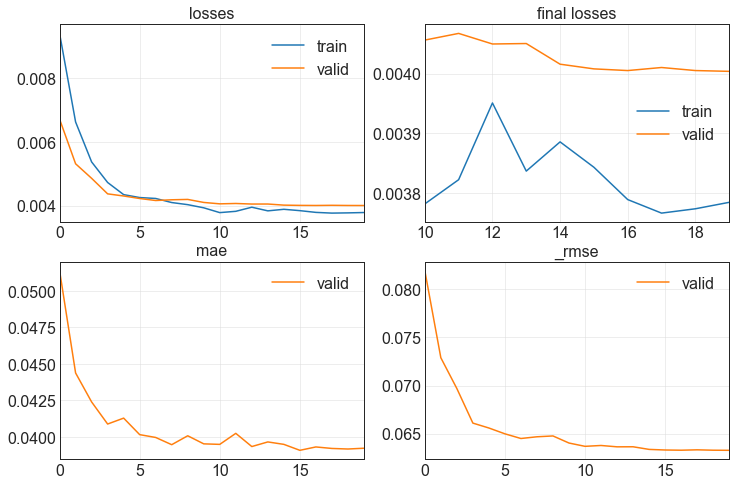

199.17762780189514                                                                                                     
[0.0037839708384126425, 0.004003848880529404, 0.03922177851200104, 0.06327598541975021]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 65%|█████████████████████████▎             | 65/100 [3:09:25<1:35:04, 162.99s/trial, best loss: 0.0028882252518087626]

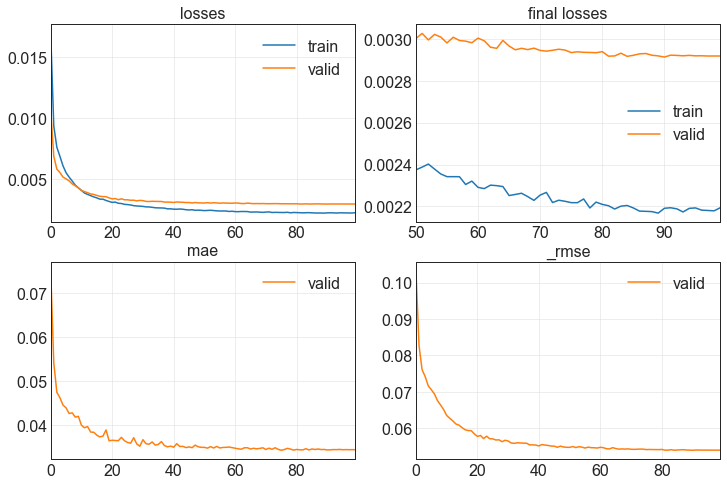

271.4502213001251                                                                                                      
[0.0021937370765954256, 0.002918114885687828, 0.034517500549554825, 0.05401958152651787]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 66%|█████████████████████████▋             | 66/100 [3:14:01<1:51:36, 196.97s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 89: early stopping                                                                          
 66%|█████████████████████████▋             | 66/100 [3:18:31<1:51:36, 196.97s/trial, best loss: 0.0028882252518087626]

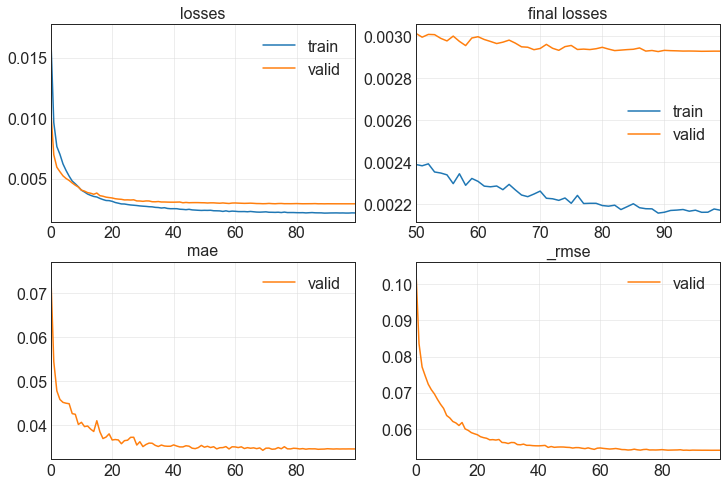

271.1142055988312                                                                                                      
[0.0021726638078689575, 0.0029277214780449867, 0.03457550331950188, 0.05410842224955559]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 67%|██████████████████████████▏            | 67/100 [3:18:37<2:01:21, 220.64s/trial, best loss: 0.0028882252518087626]

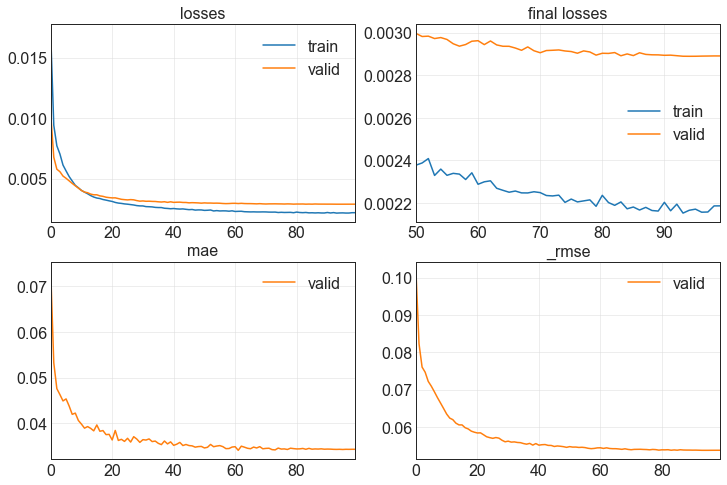

271.49698281288147                                                                                                     
[0.00218613026663661, 0.0028900932520627975, 0.034281592816114426, 0.05375958979129791]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 68%|██████████████████████████▌            | 68/100 [3:23:13<2:06:34, 237.32s/trial, best loss: 0.0028882252518087626]

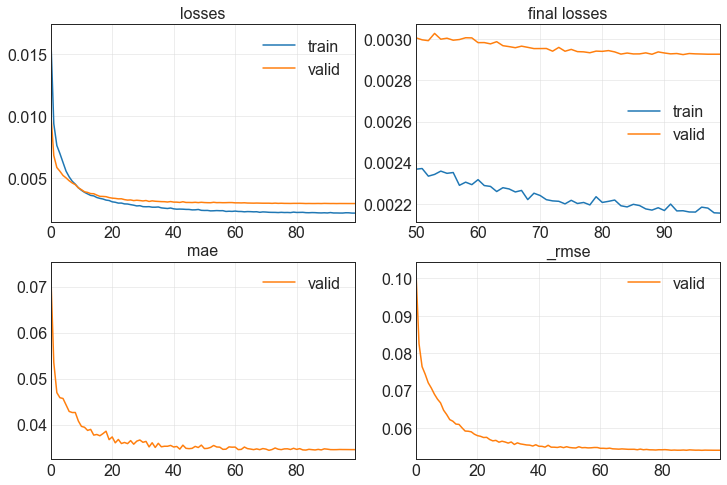

270.8461546897888                                                                                                      
[0.0021546129137277603, 0.002927773864939809, 0.034570757299661636, 0.054108910262584686]                              
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 69%|██████████████████████████▉            | 69/100 [3:27:49<2:08:33, 248.83s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 81: early stopping                                                                          
 69%|██████████████████████████▉            | 69/100 [3:31:57<2:08:33, 248.83s/trial, best loss: 0.0028882252518087626]

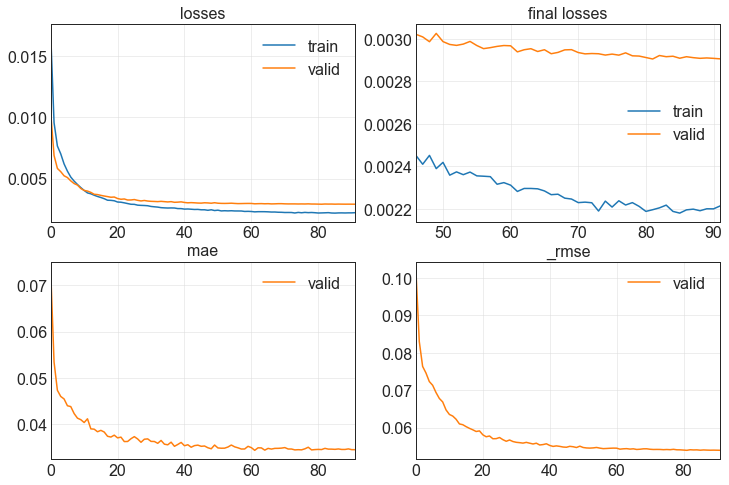

249.38693237304688                                                                                                     
[0.002213480183854699, 0.0029060454107820988, 0.03450741246342659, 0.05390774831175804]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 70%|███████████████████████████▎           | 70/100 [3:32:03<2:05:12, 250.43s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 87: early stopping                                                                          
 70%|███████████████████████████▎           | 70/100 [3:36:28<2:05:12, 250.43s/trial, best loss: 0.0028882252518087626]

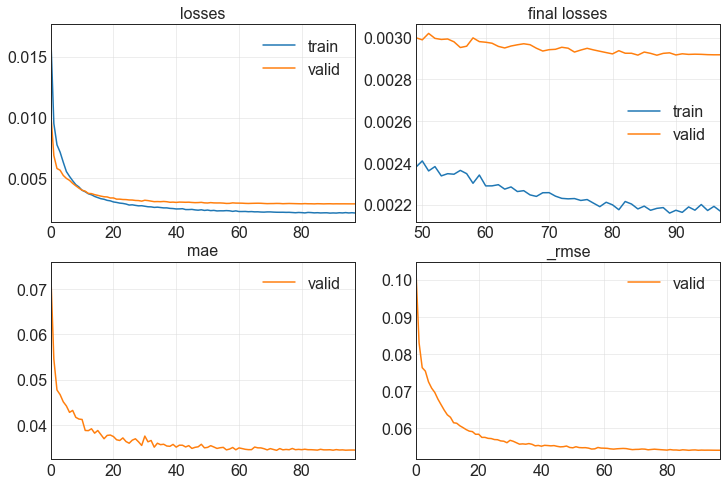

265.303373336792                                                                                                       
[0.002168314065784216, 0.0029174915980547667, 0.03446377068758011, 0.05401381850242615]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 71%|███████████████████████████▋           | 71/100 [3:36:33<2:03:53, 256.32s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 77: early stopping                                                                          
 71%|███████████████████████████▋           | 71/100 [3:38:40<2:03:53, 256.32s/trial, best loss: 0.0028882252518087626]

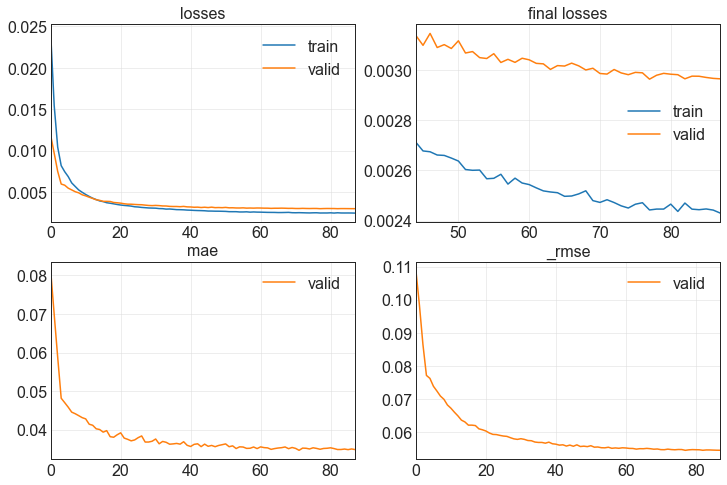

127.31940007209778                                                                                                     
[0.0024296992924064398, 0.002966089639812708, 0.03483743593096733, 0.05446182191371918]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 72%|████████████████████████████           | 72/100 [3:38:45<1:42:13, 219.05s/trial, best loss: 0.0028882252518087626]

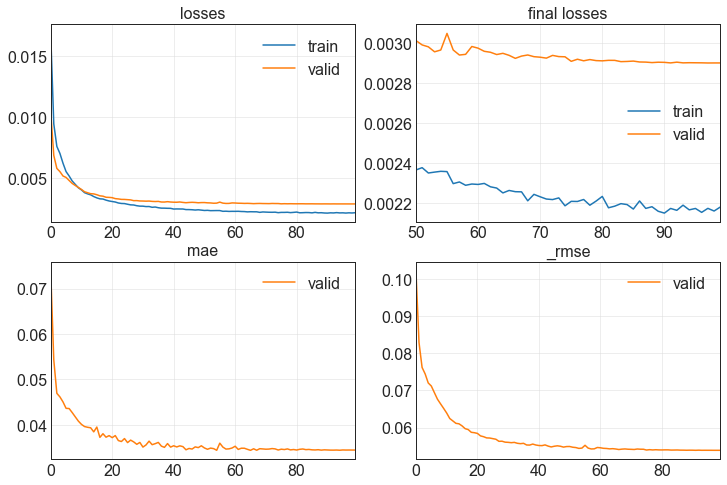

270.9051089286804                                                                                                      
[0.0021797497756779194, 0.002900768769904971, 0.03445800021290779, 0.05385877937078476]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 73%|████████████████████████████▍          | 73/100 [3:43:20<1:46:12, 236.03s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 65: early stopping                                                                          
 73%|████████████████████████████▍          | 73/100 [3:46:46<1:46:12, 236.03s/trial, best loss: 0.0028882252518087626]

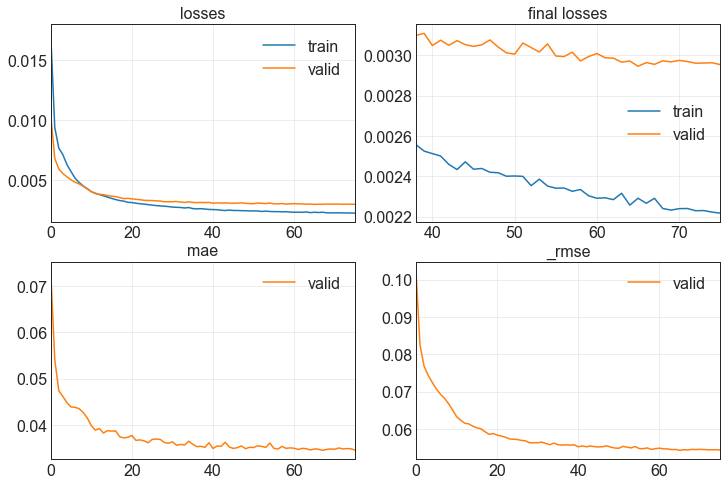

206.07404851913452                                                                                                     
[0.0022168562281876802, 0.0029536716174334288, 0.03455077484250069, 0.0543476939201355]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 74%|████████████████████████████▊          | 74/100 [3:46:51<1:39:00, 228.47s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 28: early stopping                                                                          
 74%|████████████████████████████▊          | 74/100 [3:53:23<1:39:00, 228.47s/trial, best loss: 0.0028882252518087626]

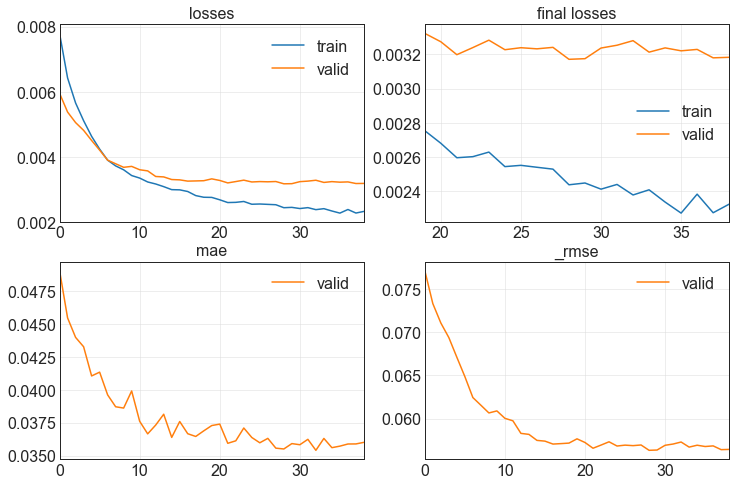

392.53881216049194                                                                                                     
[0.002323569031432271, 0.0031832323875278234, 0.03601285070180893, 0.056420136243104935]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 75%|█████████████████████████████▎         | 75/100 [3:53:29<1:56:17, 279.12s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 11: early stopping                                                                          
 75%|█████████████████████████████▎         | 75/100 [3:54:28<1:56:17, 279.12s/trial, best loss: 0.0028882252518087626]

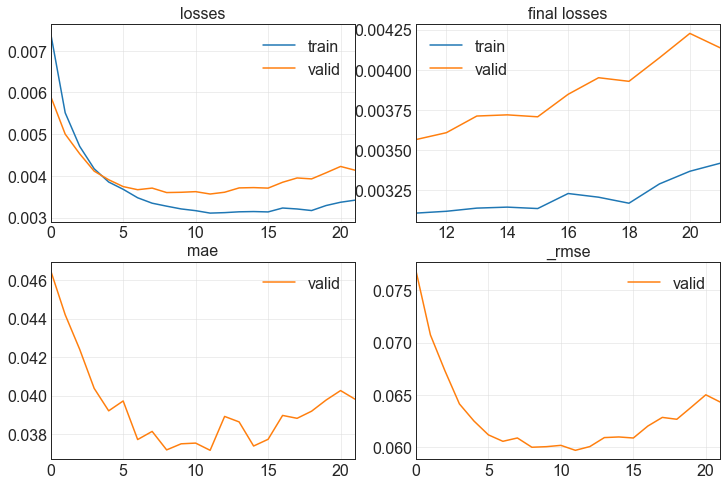

59.71448636054993                                                                                                      
[0.0034195706248283386, 0.004136953502893448, 0.03981615975499153, 0.06431915611028671]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 76%|█████████████████████████████▋         | 76/100 [3:54:33<1:25:53, 214.73s/trial, best loss: 0.0028882252518087626]

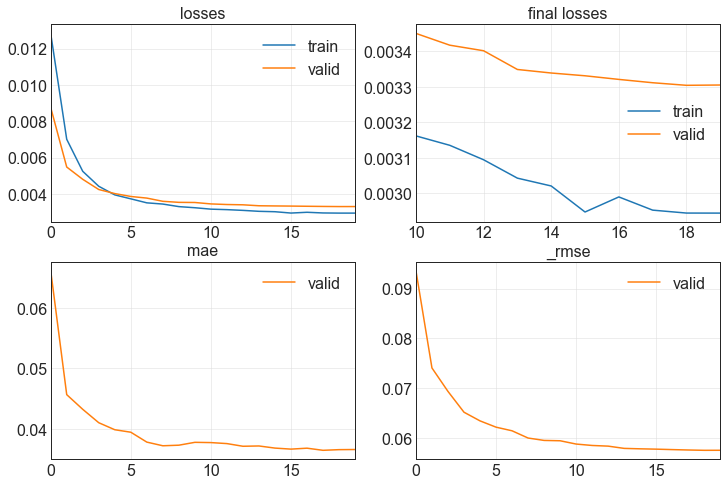

54.26342034339905                                                                                                      
[0.0029446082189679146, 0.0033053457736968994, 0.03658093512058258, 0.05749213322997093]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 77%|██████████████████████████████         | 77/100 [3:55:32<1:04:24, 168.01s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 89: early stopping                                                                          
 77%|██████████████████████████████         | 77/100 [3:57:56<1:04:24, 168.01s/trial, best loss: 0.0028882252518087626]

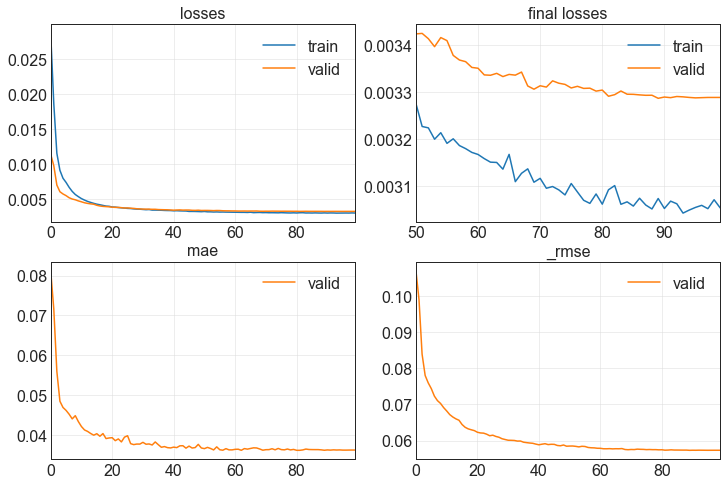

144.30125164985657                                                                                                     
[0.0030543403699994087, 0.0032884327229112387, 0.03619275242090225, 0.05734485387802124]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 78%|███████████████████████████████▉         | 78/100 [3:58:01<59:30, 162.31s/trial, best loss: 0.0028882252518087626]

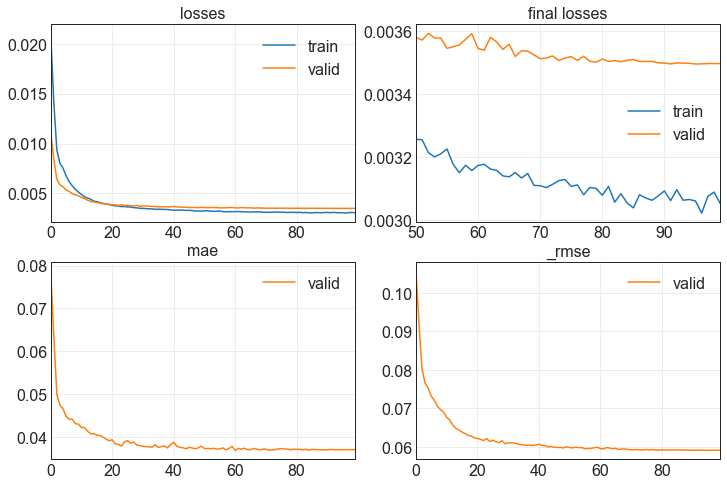

263.24179315567017                                                                                                     
[0.0030510909855365753, 0.0034962815698236227, 0.0370323620736599, 0.059129368513822556]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 79%|██████████████████████████████▊        | 79/100 [4:02:29<1:07:54, 194.00s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 5: early stopping                                                                           
 79%|██████████████████████████████▊        | 79/100 [4:05:10<1:07:54, 194.00s/trial, best loss: 0.0028882252518087626]

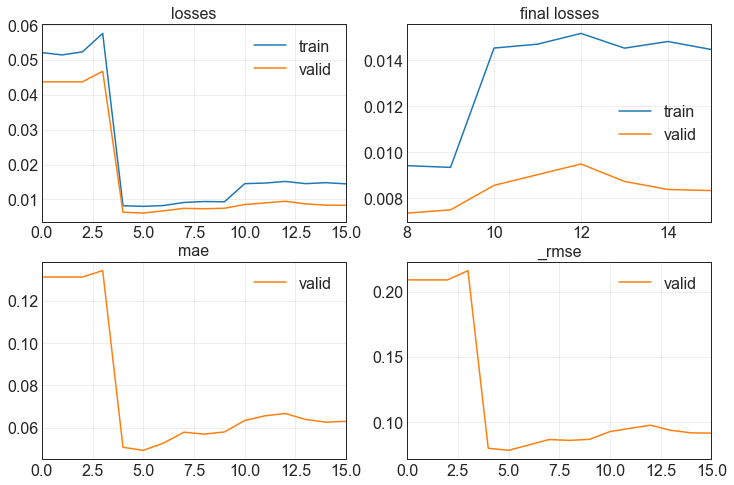

161.20930409431458                                                                                                     
[0.014471657574176788, 0.008336138911545277, 0.0629572868347168, 0.09130245447158813]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 80%|███████████████████████████████▏       | 80/100 [4:05:15<1:01:52, 185.60s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 10: early stopping                                                                          
 80%|███████████████████████████████▏       | 80/100 [4:06:11<1:01:52, 185.60s/trial, best loss: 0.0028882252518087626]

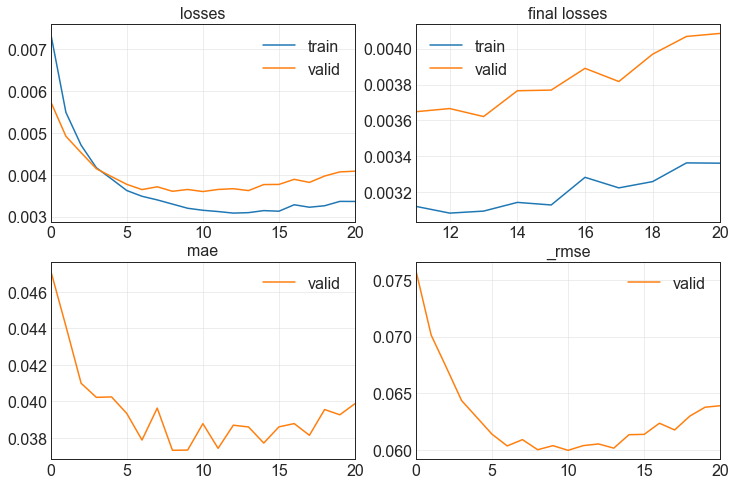

56.79437589645386                                                                                                      
[0.003362129209563136, 0.0040852343663573265, 0.03987668827176094, 0.06391584873199463]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 81%|█████████████████████████████████▏       | 81/100 [4:06:17<46:59, 148.38s/trial, best loss: 0.0028882252518087626]

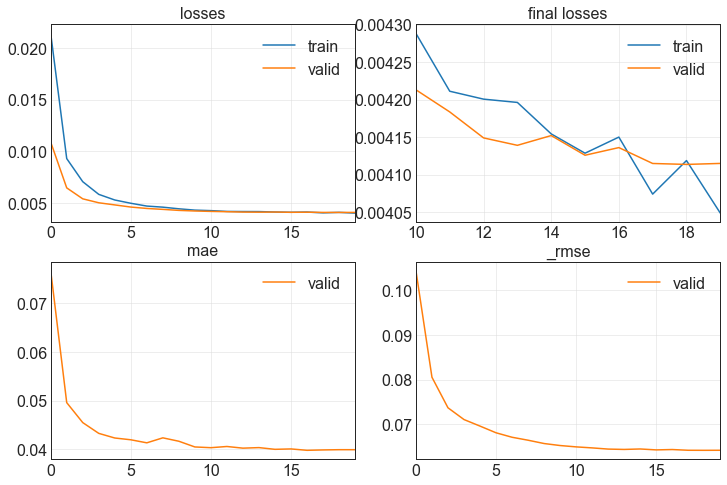

52.252965450286865                                                                                                     
[0.004048794507980347, 0.004114983603358269, 0.03995401784777641, 0.06414814293384552]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 82%|█████████████████████████████████▌       | 82/100 [4:07:13<36:17, 120.95s/trial, best loss: 0.0028882252518087626]

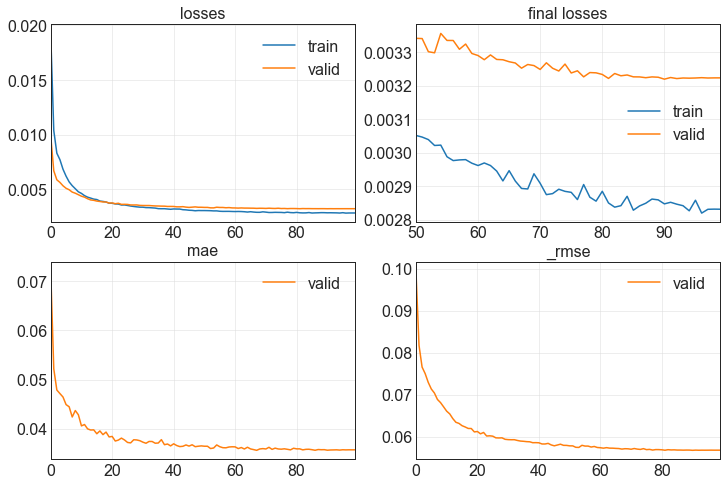

270.59518003463745                                                                                                     
[0.002831260906532407, 0.003223005449399352, 0.03569657728075981, 0.056771520525217056]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 83%|██████████████████████████████████       | 83/100 [4:11:49<47:23, 167.26s/trial, best loss: 0.0028882252518087626]

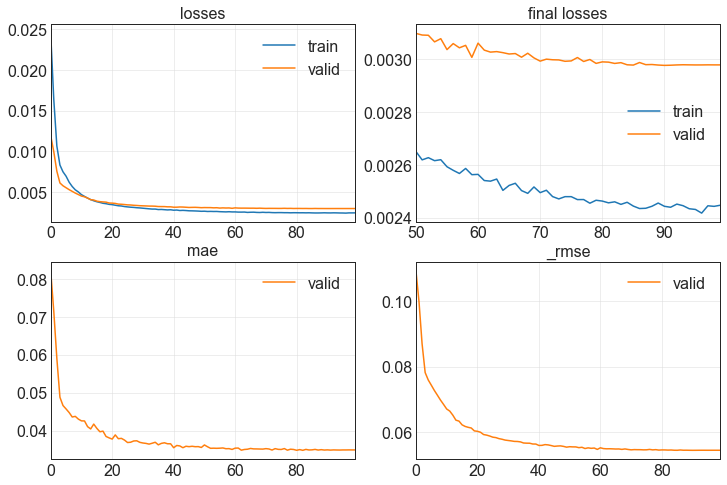

144.31929898262024                                                                                                     
[0.0024468821939080954, 0.002978014061227441, 0.034895725548267365, 0.054571185261011124]                              
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 84%|██████████████████████████████████▍      | 84/100 [4:14:18<43:08, 161.80s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 2: early stopping                                                                           
 84%|██████████████████████████████████▍      | 84/100 [4:14:52<43:08, 161.80s/trial, best loss: 0.0028882252518087626]

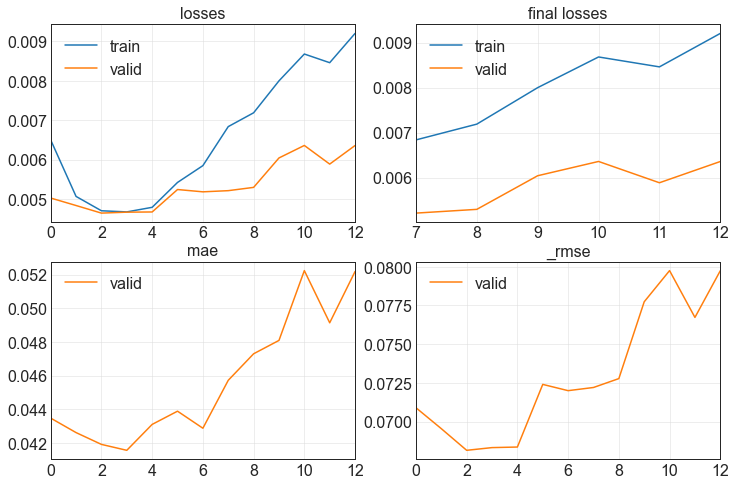

34.51248860359192                                                                                                      
[0.00920436903834343, 0.006358991842716932, 0.0521838404238224, 0.07974329590797424]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 85%|██████████████████████████████████▊      | 85/100 [4:14:57<31:15, 125.03s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 65: early stopping                                                                          
 85%|██████████████████████████████████▊      | 85/100 [4:18:23<31:15, 125.03s/trial, best loss: 0.0028882252518087626]

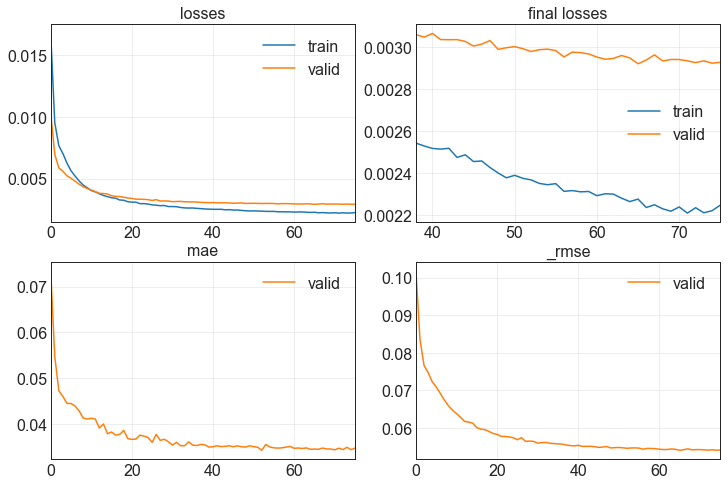

205.84766674041748                                                                                                     
[0.0022458548191934824, 0.002928702859207988, 0.03471403941512108, 0.054117489606142044]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 86%|███████████████████████████████████▎     | 86/100 [4:18:28<35:09, 150.68s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 2: early stopping                                                                           
 86%|███████████████████████████████████▎     | 86/100 [4:20:36<35:09, 150.68s/trial, best loss: 0.0028882252518087626]

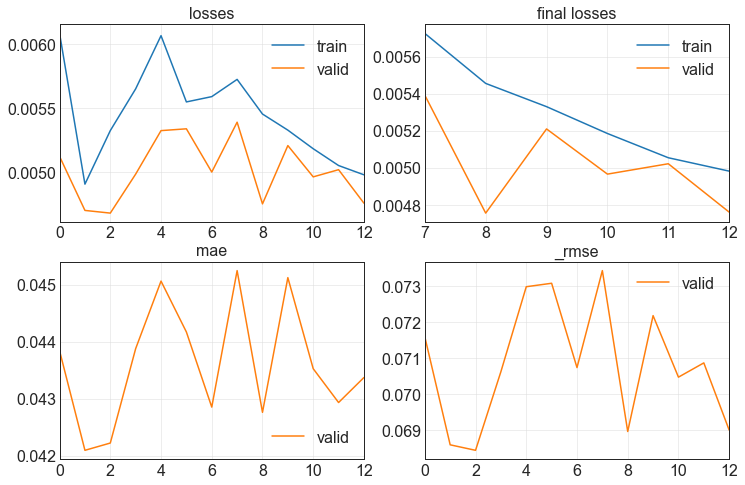

128.62841987609863                                                                                                     
[0.004981493577361107, 0.00476020248606801, 0.0433700792491436, 0.06899422407150269]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 87%|███████████████████████████████████▋     | 87/100 [4:20:41<31:31, 145.47s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 88: early stopping                                                                          
 87%|███████████████████████████████████▋     | 87/100 [4:25:09<31:31, 145.47s/trial, best loss: 0.0028882252518087626]

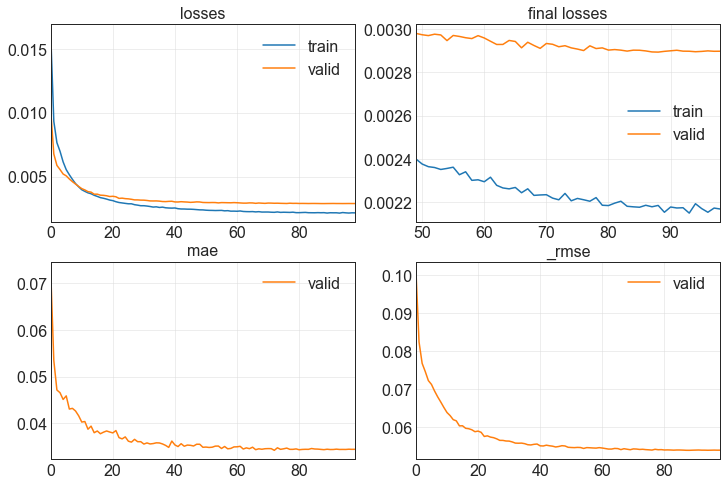

268.46648645401                                                                                                        
[0.002167406026273966, 0.0028977200854569674, 0.034352049231529236, 0.053830478340387344]                              
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 88%|████████████████████████████████████     | 88/100 [4:25:14<36:45, 183.79s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 89: early stopping                                                                          
 88%|████████████████████████████████████     | 88/100 [4:29:45<36:45, 183.79s/trial, best loss: 0.0028882252518087626]

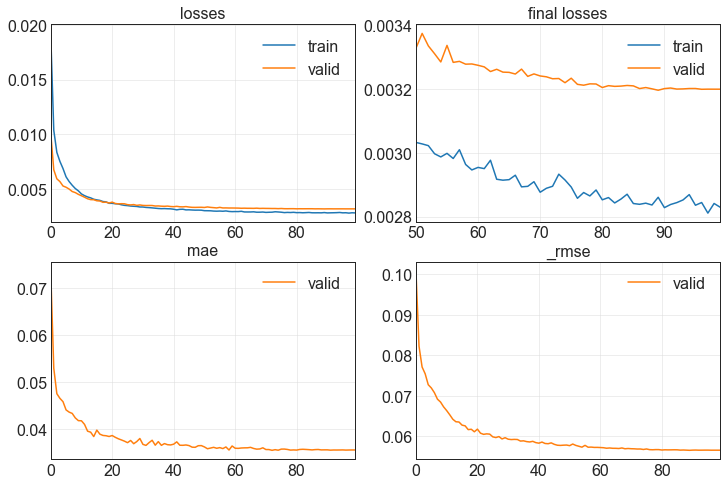

271.09572863578796                                                                                                     
[0.002829371951520443, 0.003198756370693445, 0.03551267832517624, 0.056557539850473404]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 89%|████████████████████████████████████▍    | 89/100 [4:29:50<38:45, 211.40s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 86: early stopping                                                                          
 89%|████████████████████████████████████▍    | 89/100 [4:32:08<38:45, 211.40s/trial, best loss: 0.0028882252518087626]

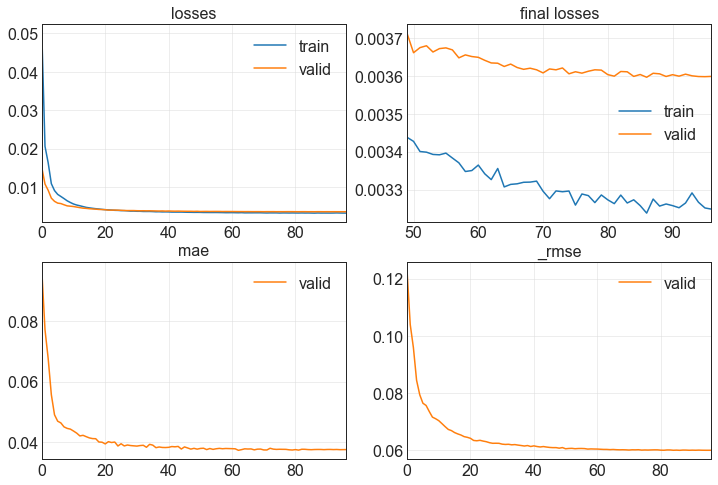

138.44312953948975                                                                                                     
[0.0032483949325978756, 0.0035986353177577257, 0.03763134405016899, 0.059988632798194885]                              
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 90%|████████████████████████████████████▉    | 90/100 [4:32:13<31:49, 190.95s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 18: early stopping                                                                          
 90%|████████████████████████████████████▉    | 90/100 [4:33:32<31:49, 190.95s/trial, best loss: 0.0028882252518087626]

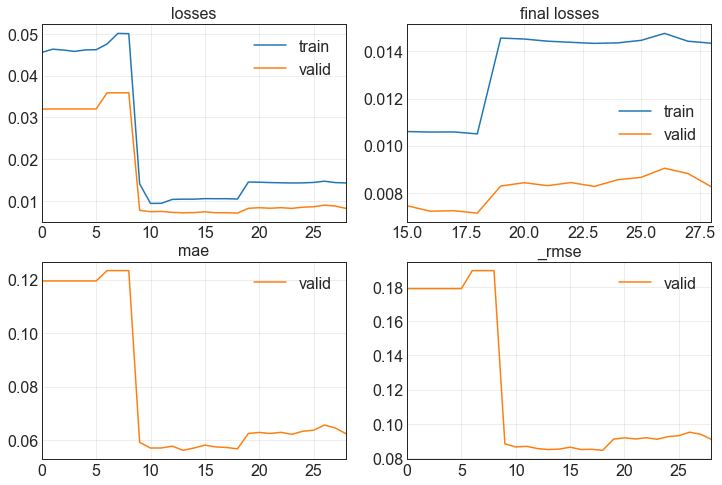

78.84849309921265                                                                                                      
[0.014346420764923096, 0.008256286382675171, 0.062375135719776154, 0.09086410701274872]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 91%|█████████████████████████████████████▎   | 91/100 [4:33:37<23:48, 158.74s/trial, best loss: 0.0028882252518087626]

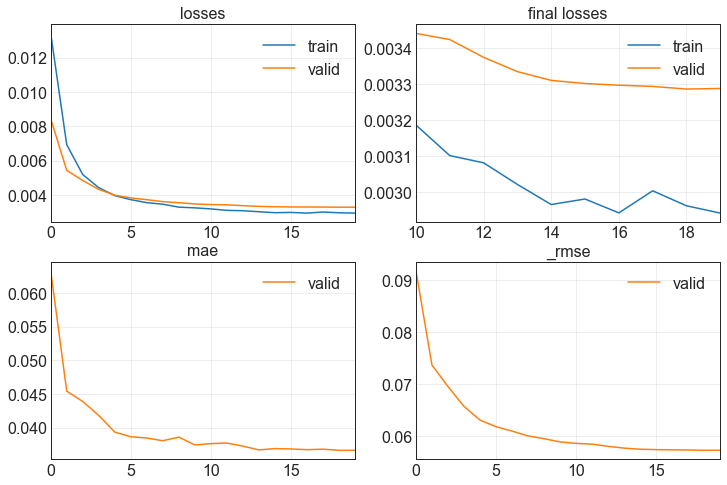

54.19957947731018                                                                                                      
[0.0029412086587399244, 0.003287213621661067, 0.036638472229242325, 0.05733422935009003]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 92%|█████████████████████████████████████▋   | 92/100 [4:34:36<17:10, 128.79s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 6: early stopping                                                                           
 92%|█████████████████████████████████████▋   | 92/100 [4:37:24<17:10, 128.79s/trial, best loss: 0.0028882252518087626]

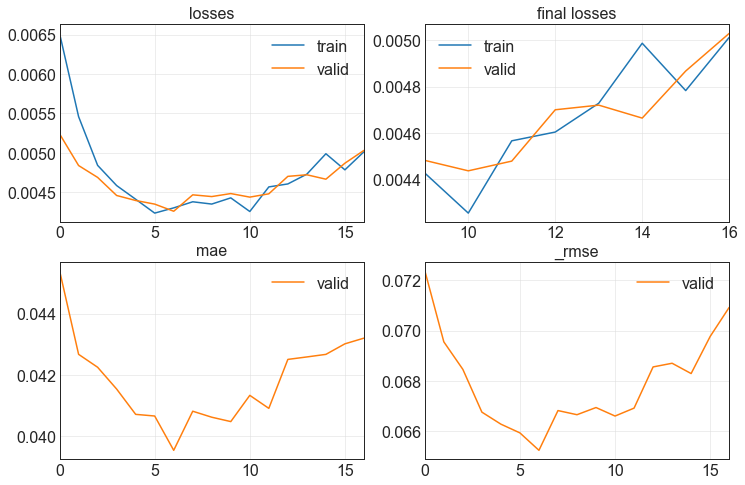

168.3476107120514                                                                                                      
[0.0050127748399972916, 0.005030122585594654, 0.043198224157094955, 0.07092338055372238]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 93%|██████████████████████████████████████▏  | 93/100 [4:37:29<16:34, 142.07s/trial, best loss: 0.0028882252518087626]

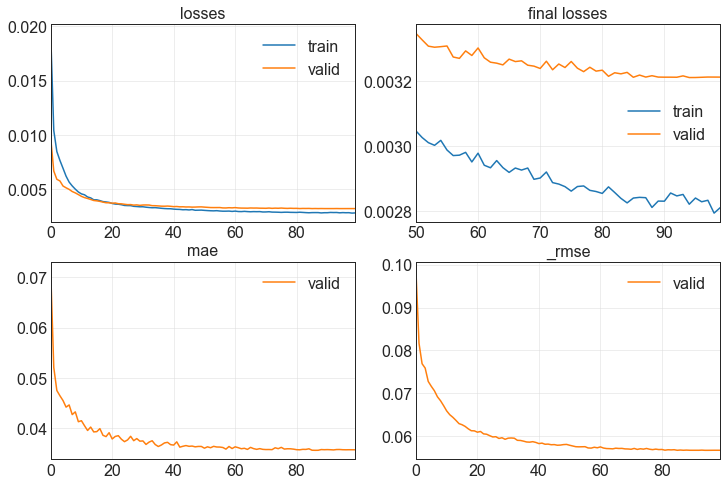

285.85522627830505                                                                                                     
[0.002811692887917161, 0.0032115369103848934, 0.03567376732826233, 0.056670427322387695]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 94%|██████████████████████████████████████▌  | 94/100 [4:42:20<18:40, 186.72s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 32: early stopping                                                                          
 94%|██████████████████████████████████████▌  | 94/100 [4:46:16<18:40, 186.72s/trial, best loss: 0.0028882252518087626]

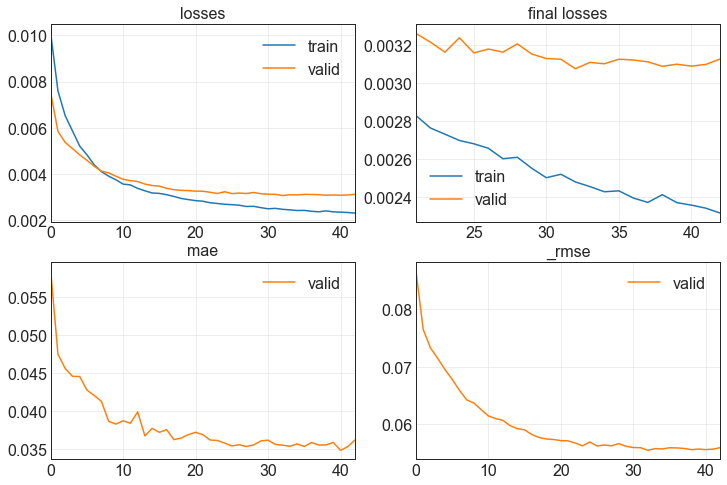

236.5713984966278                                                                                                      
[0.0023175980895757675, 0.0031290645711123943, 0.03618749976158142, 0.05593803897500038]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 95%|██████████████████████████████████████▉  | 95/100 [4:46:21<16:55, 203.14s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 1: early stopping                                                                           
 95%|██████████████████████████████████████▉  | 95/100 [4:46:40<16:55, 203.14s/trial, best loss: 0.0028882252518087626]

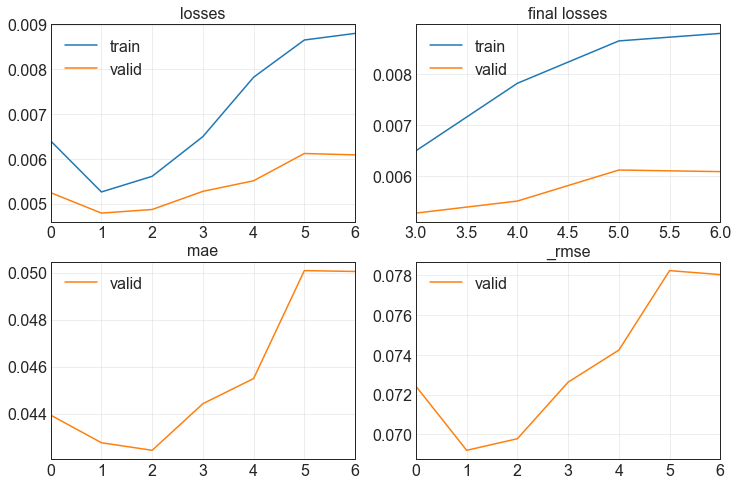

19.09968662261963                                                                                                      
[0.008804986253380775, 0.006089457776397467, 0.0500502809882164, 0.07803498953580856]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 96%|███████████████████████████████████████▎ | 96/100 [4:46:45<09:57, 149.36s/trial, best loss: 0.0028882252518087626]

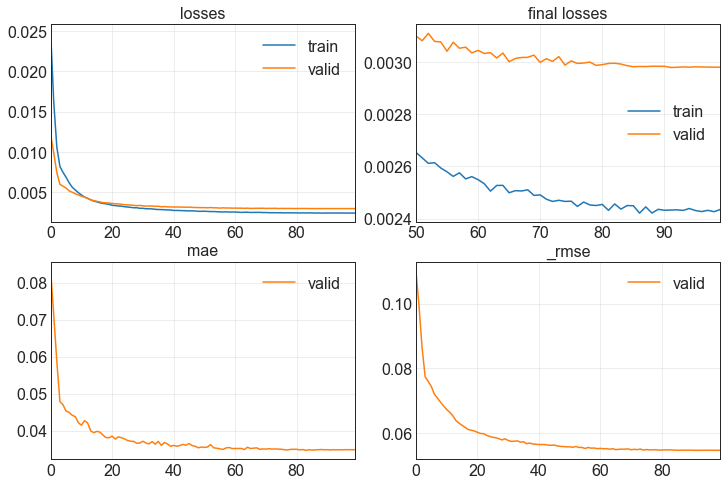

146.02483582496643                                                                                                     
[0.0024354096967726946, 0.002980260644108057, 0.03486814349889755, 0.05459176376461983]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 97%|███████████████████████████████████████▊ | 97/100 [4:49:16<07:29, 149.81s/trial, best loss: 0.0028882252518087626]

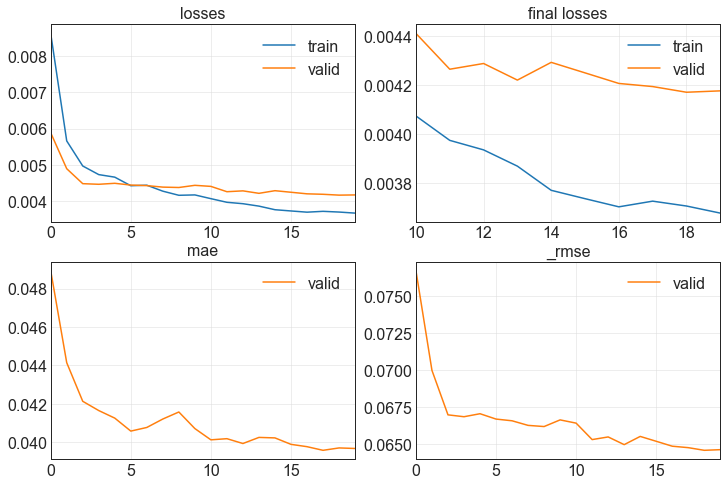

52.774683475494385                                                                                                     
[0.0036768270656466484, 0.004177028778940439, 0.03968580812215805, 0.0646299421787262]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}
MLP                                                                                                                    
 98%|████████████████████████████████████████▏| 98/100 [4:50:13<04:04, 122.12s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 89: early stopping                                                                          
 98%|████████████████████████████████████████▏| 98/100 [4:55:02<04:04, 122.12s/trial, best loss: 0.0028882252518087626]

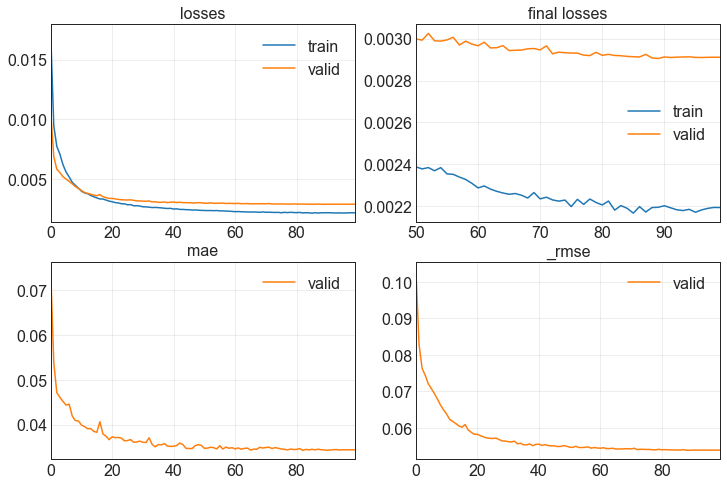

288.5638654232025                                                                                                      
[0.0021946346387267113, 0.0029108403250575066, 0.03442630544304848, 0.053952209651470184]                              
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 5}
MLP                                                                                                                    
 99%|████████████████████████████████████████▌| 99/100 [4:55:07<02:53, 173.47s/trial, best loss: 0.0028882252518087626]

No improvement since epoch 39: early stopping                                                                          
 99%|████████████████████████████████████████▌| 99/100 [5:02:49<02:53, 173.47s/trial, best loss: 0.0028882252518087626]

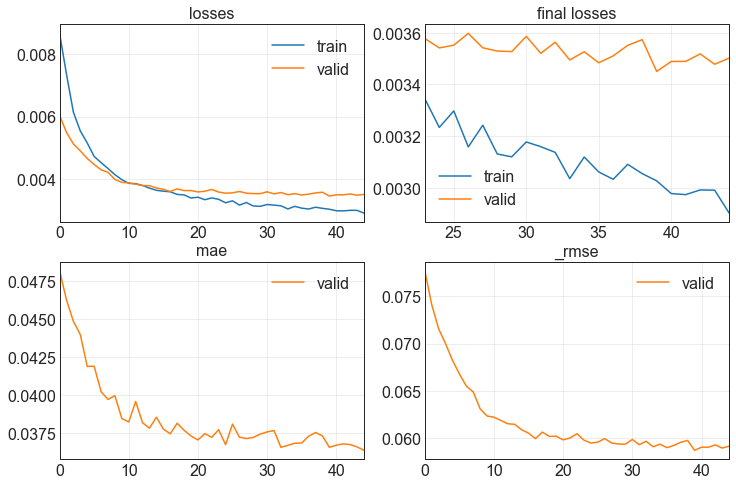

461.86812567710876                                                                                                     
[0.0029025678522884846, 0.0035020376089960337, 0.03637661412358284, 0.05917802453041077]                               
100%|████████████████████████████████████████| 100/100 [5:02:49<00:00, 181.70s/trial, best loss: 0.0028882252518087626]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000289320C8438>, 'patience': 10}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(38467, 144, 10)

In [62]:
y.shape

(38467, 144)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = MLP
k = {
    'layers': params['layers'],
    'fc_dropout': params['fc_dropout']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

MLP


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): MLP(
    (flatten): Reshape(bs, -1)
    (mlp): ModuleList(
      (0): LinBnDrop(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=1440, out_features=500, bias=True)
        (2): ReLU(inplace=True)
      )
      (1): LinBnDrop(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=500, out_features=500, bias=True)
        (2): ReLU(inplace=True)
      )
      (2): LinBnDrop(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=500, out_features=500, bias=True)
        (2): ReLU(inplace=True)
      )
    )
    (head): Sequential(
      (0): LinBnDrop(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=500, out_features=144, bias=True)
      )
    )
  )
  (1): Sigmoid()
)

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,293,644 total parameters.
1,293,644 training parameters.


Training the model:

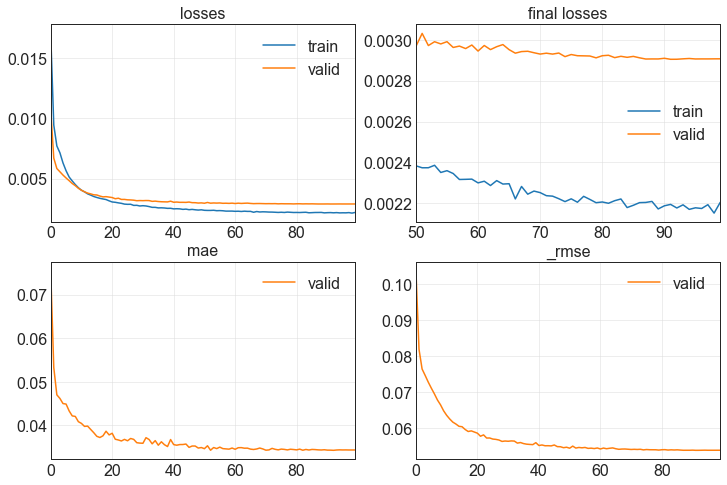

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

9619


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0071, 0.0124, 0.0387,  ..., 0.0365, 0.2321, 0.9313],
         [0.0065, 0.0124, 0.0361,  ..., 0.0307, 0.2296, 0.9230],
         [0.0066, 0.0113, 0.0312,  ..., 0.0333, 0.2110, 0.9096],
         ...,
         [0.0231, 0.0519, 0.0973,  ..., 0.1011, 0.4312, 0.9921],
         [0.0281, 0.0596, 0.1028,  ..., 0.1048, 0.4254, 0.9906],
         [0.0278, 0.0557, 0.1067,  ..., 0.0986, 0.4354, 0.9879]]),
 tensor([[0.0000, 0.0020, 0.0167,  ..., 0.0065, 0.2165, 0.8989],
         [0.0000, 0.0040, 0.0109,  ..., 0.0057, 0.2154, 0.7845],
         [0.0000, 0.0020, 0.0082,  ..., 0.0079, 0.2064, 1.0000],
         ...,
         [0.6255, 0.0400, 0.1464,  ..., 0.0790, 0.4122, 0.8162],
         [0.6294, 0.0634, 0.2009,  ..., 0.0886, 0.4169, 0.7650],
         [0.4050, 0.0551, 0.1543,  ..., 0.0931, 0.3980, 0.9314]]),
 tensor([[0.0071, 0.0124, 0.0387,  ..., 0.0365, 0.2321, 0.9313],
         [0.0065, 0.0124, 0.0361,  ..., 0.0307, 0.2296, 0.9230],
         [0.0066, 0.0113, 0.0312,  ..., 0.0333, 0.2110, 0.

In [73]:
test_targets.shape

torch.Size([9619, 144])

In [74]:
test_preds.shape

torch.Size([9619, 144])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(9619, 1, 144)

In [78]:
y_pred.shape

(9619, 1, 144)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(9619, 1, 144)

In [83]:
y_pred.shape

(9619, 1, 144)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  270.8364968299866
Test time (in seconds):  0.584885835647583


In [92]:
print('Training time (in seconds) per epoch: ', 270.8364968299866 / 100)

Training time (in seconds) per epoch:  2.7083649682998656


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  12.866219580199662
MAE:  6.572879627943532


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

MLP_TM-minmax_RMSE-10-1-step-1.pdf
MLP_TM-minmax_MAE-10-1-step-1.pdf


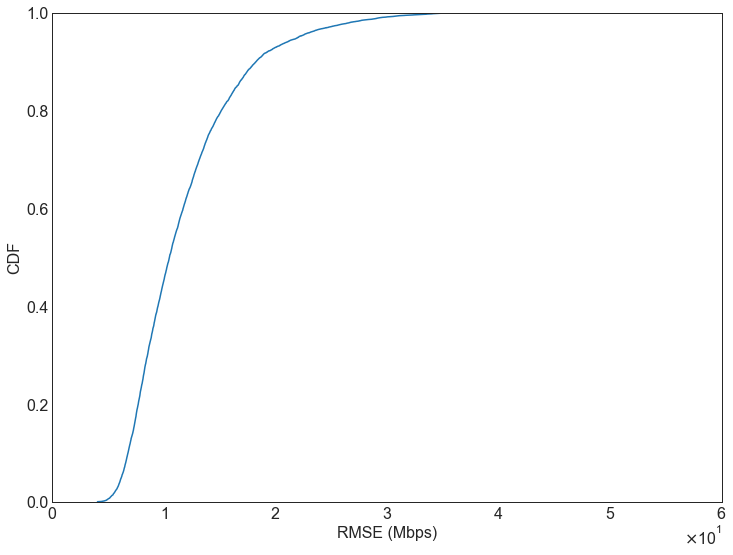

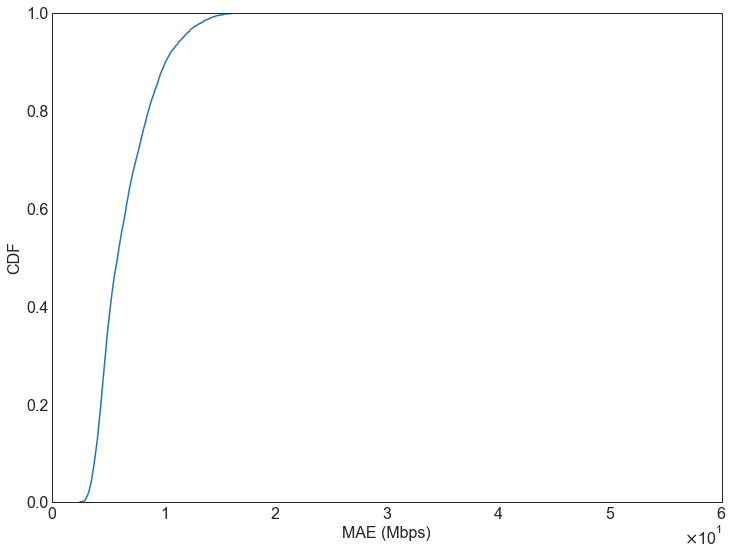

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)